<a href="https://colab.research.google.com/github/willmbennett/meld_calc/blob/main/mimic_iv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In [1]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [2]:
# GDRIVE local files
from google.colab import drive
# drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Flatiron/phase 5/colab')

In [3]:
sys.path

['/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/MyDrive/Flatiron/phase 5/colab']

In [4]:
!pip install sklego

In [5]:
import pandas as pd
import numpy as np
import math
from scipy.stats import loguniform
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

# Sklearn Modeling
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, recall_score,accuracy_score, \
    precision_score, f1_score, classification_report, silhouette_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest

# Sklego
from sklego.preprocessing import IdentityTransformer
from sklego.meta import EstimatorTransformer

# Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

# Local files from google drive
# from model_handling import ModelStorer, SaveModel

In [6]:
%load_ext google.colab.data_table

In [7]:
%%bigquery df --project mimic-iv-388714
SELECT ie.stay_id
       ,id.admittime
       ,id.dod
       ,id.race
       ,id.gender
       ,id.admission_age as age
       ,labs.*
       ,r.dialysis_present
       ,m.meld_initial
       ,m.meld
       ,case when id.dod <= CAST(DATETIME_ADD(id.admittime, INTERVAL 90 DAY) AS DATE) then 1 else 0 end as target
FROM `physionet-data.mimiciv_icu.icustays` ie
JOIN `physionet-data.mimiciv_derived.icustay_detail` id ON id.stay_id = ie.stay_id
JOIN `physionet-data.mimiciv_derived.meld` m on m.stay_id =  ie.stay_id
JOIN `mimic-iv-388714.cirrhosis_patients.icd_codes` cohort on cohort.hadm_id = ie.hadm_id
LEFT JOIN `physionet-data.mimiciv_derived.first_day_lab` labs ON ie.stay_id = labs.stay_id
LEFT JOIN `physionet-data.mimiciv_derived.first_day_rrt` r ON ie.stay_id = r.stay_id

Query is running:   0%|          |

Downloading:   0%|          |

In [8]:
df.head()

stay_id           admittime  dod                race gender  age  \
0  30880402 2112-11-19 02:39:00  NaT             UNKNOWN      F   18   
1  39804513 2119-08-10 03:29:00  NaT             UNKNOWN      F   18   
2  37684466 2163-12-16 17:23:00  NaT    UNABLE TO OBTAIN      M   18   
3  37794684 2135-01-23 23:36:00  NaT             UNKNOWN      F   18   
4  35542486 2166-07-07 08:18:00  NaT  HISPANIC OR LATINO      M   18   

   subject_id  stay_id_1  hematocrit_min  hematocrit_max  ...  ck_mb_min  \
0    19077387   30880402            32.8            35.6  ...        NaN   
1    10141487   39804513            33.4            33.4  ...        NaN   
2    19671351   37684466            40.0            40.0  ...        NaN   
3    16897601   37794684            40.7            40.7  ...        1.0   
4    11519044   35542486            26.0            41.4  ...        NaN   

   ck_mb_max  ggt_min  ggt_max  ld_ldh_min  ld_ldh_max  dialysis_present  \
0        NaN      NaN      NaN       213.0       213.0              <NA>   
1        NaN      NaN      NaN         NaN         NaN              <NA>   
2        NaN      NaN      NaN         NaN         NaN              <NA>   
3        1.0      NaN      NaN         NaN         NaN              <NA>   
4        NaN      NaN      NaN         NaN         NaN              <NA>   

   meld_initial  meld  target  
0   8.000000000   8.0       0  
1   7.000000000   7.0       0  
2   6.000000000   6.0       0  
3   6.000000000   6.0       0  
4   9.000000000   9.0       0  

[5 rows x 98 columns]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11381 entries, 0 to 11380
Data columns (total 98 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   stay_id                 11381 non-null  Int64         
 1   admittime               11381 non-null  datetime64[ns]
 2   dod                     4683 non-null   dbdate        
 3   race                    11381 non-null  object        
 4   gender                  11381 non-null  object        
 5   age                     11381 non-null  Int64         
 6   subject_id              11381 non-null  Int64         
 7   stay_id_1               11381 non-null  Int64         
 8   hematocrit_min          11292 non-null  float64       
 9   hematocrit_max          11292 non-null  float64       
 10  hemoglobin_min          11281 non-null  float64       
 11  hemoglobin_max          11281 non-null  float64       
 12  platelets_min           11283 non-null  float6

# Data Cleaning

In [10]:
df_clean = df.drop(['admittime','dod', 'meld', 'meld_initial', 'stay_id', 'subject_id', 'stay_id_1'], axis=1) # drop date of death and time of admission

## Handling Missing Data

Let's start by dropping columns with < 60% of data

In [11]:
thresh = len(df_clean)*0.6
thresh

6828.599999999999

In [12]:
df_clean.dropna(axis=1, thresh=thresh, inplace=True)

In [13]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11381 entries, 0 to 11380
Data columns (total 54 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   race                 11381 non-null  object 
 1   gender               11381 non-null  object 
 2   age                  11381 non-null  Int64  
 3   hematocrit_min       11292 non-null  float64
 4   hematocrit_max       11292 non-null  float64
 5   hemoglobin_min       11281 non-null  float64
 6   hemoglobin_max       11281 non-null  float64
 7   platelets_min        11283 non-null  float64
 8   platelets_max        11283 non-null  float64
 9   wbc_min              11284 non-null  float64
 10  wbc_max              11284 non-null  float64
 11  aniongap_min         11259 non-null  float64
 12  aniongap_max         11259 non-null  float64
 13  bicarbonate_min      11263 non-null  float64
 14  bicarbonate_max      11263 non-null  float64
 15  bun_min              11295 non-null 

In [14]:
cols_to_convert = list(df_clean.select_dtypes(object).drop(['race','gender'], axis=1).columns)

for col in cols_to_convert:
  df_clean[col] = df_clean.loc[:, col].astype(float)

In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11381 entries, 0 to 11380
Data columns (total 54 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   race                 11381 non-null  object 
 1   gender               11381 non-null  object 
 2   age                  11381 non-null  Int64  
 3   hematocrit_min       11292 non-null  float64
 4   hematocrit_max       11292 non-null  float64
 5   hemoglobin_min       11281 non-null  float64
 6   hemoglobin_max       11281 non-null  float64
 7   platelets_min        11283 non-null  float64
 8   platelets_max        11283 non-null  float64
 9   wbc_min              11284 non-null  float64
 10  wbc_max              11284 non-null  float64
 11  aniongap_min         11259 non-null  float64
 12  aniongap_max         11259 non-null  float64
 13  bicarbonate_min      11263 non-null  float64
 14  bicarbonate_max      11263 non-null  float64
 15  bun_min              11295 non-null 

# Data Exploration

## Numerical Variables

In [ ]:
num_cols = df_clean.select_dtypes(np.number)
num_cols['target'] = df_clean['target']
num_corr = num_cols.corr()['target'].sort_values(ascending=False)
num_corr

target                 1.000000
inr_min                0.311592
pt_min                 0.310660
ptt_min                0.309271
bun_min                0.304910
bilirubin_total_min    0.298957
bilirubin_total_max    0.296038
bun_max                0.287644
inr_max                0.255019
aniongap_min           0.229435
ptt_max                0.228953
creatinine_min         0.199332
age                    0.196814
creatinine_max         0.191094
aniongap_max           0.172857
alp_max                0.165842
abs_neutrophils_max    0.162985
wbc_max                0.153395
alp_min                0.153373
pt_max                 0.152775
wbc_min                0.152575
abs_neutrophils_min    0.151662
abs_monocytes_max      0.115115
potassium_max          0.113565
abs_monocytes_min      0.094883
potassium_min          0.094525
calcium_max            0.057826
ast_min                0.037227
glucose_max            0.035011
ast_max                0.027625
abs_eosinophils_max    0.016240
glucose_

According to [statology](https://www.statology.org/what-is-a-strong-correlation/), a weak correlation is defined as r >= 0.25

So let's investigate any variable with r >= 0.25

In [ ]:
key_cols = list(num_corr[abs(num_corr) >= 0.25].drop('target').index)
key_cols

['inr_min',
 'pt_min',
 'ptt_min',
 'bun_min',
 'bilirubin_total_min',
 'bilirubin_total_max',
 'bun_max',
 'inr_max']

In [ ]:
df_clean[key_cols].head()

inr_min  pt_min  ptt_min  bun_min  bilirubin_total_min  \
0      1.1    11.7     28.7     10.0                  1.2   
1      1.1    12.4     27.1     11.0                  NaN   
2      NaN     NaN      NaN     12.0                  0.9   
3      1.0    10.8     28.7      5.0                  0.2   
4      1.1    13.1     24.5      8.0                  NaN   

   bilirubin_total_max  bun_max  inr_max  
0                  1.2     12.0      1.1  
1                  NaN     11.0      1.1  
2                  0.9     12.0      NaN  
3                  0.2      7.0      1.0  
4                  NaN     10.0      1.2

In [ ]:
pairwise_data = df_clean[key_cols]
pairwise_data['target'] = df_clean.loc[:,'target']
pairwise_data.dropna(inplace=True)

<ipython-input-19-7f45b3cb7b41>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pairwise_data['target'] = df_clean.loc[:,'target']
<ipython-input-19-7f45b3cb7b41>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pairwise_data.dropna(inplace=True)


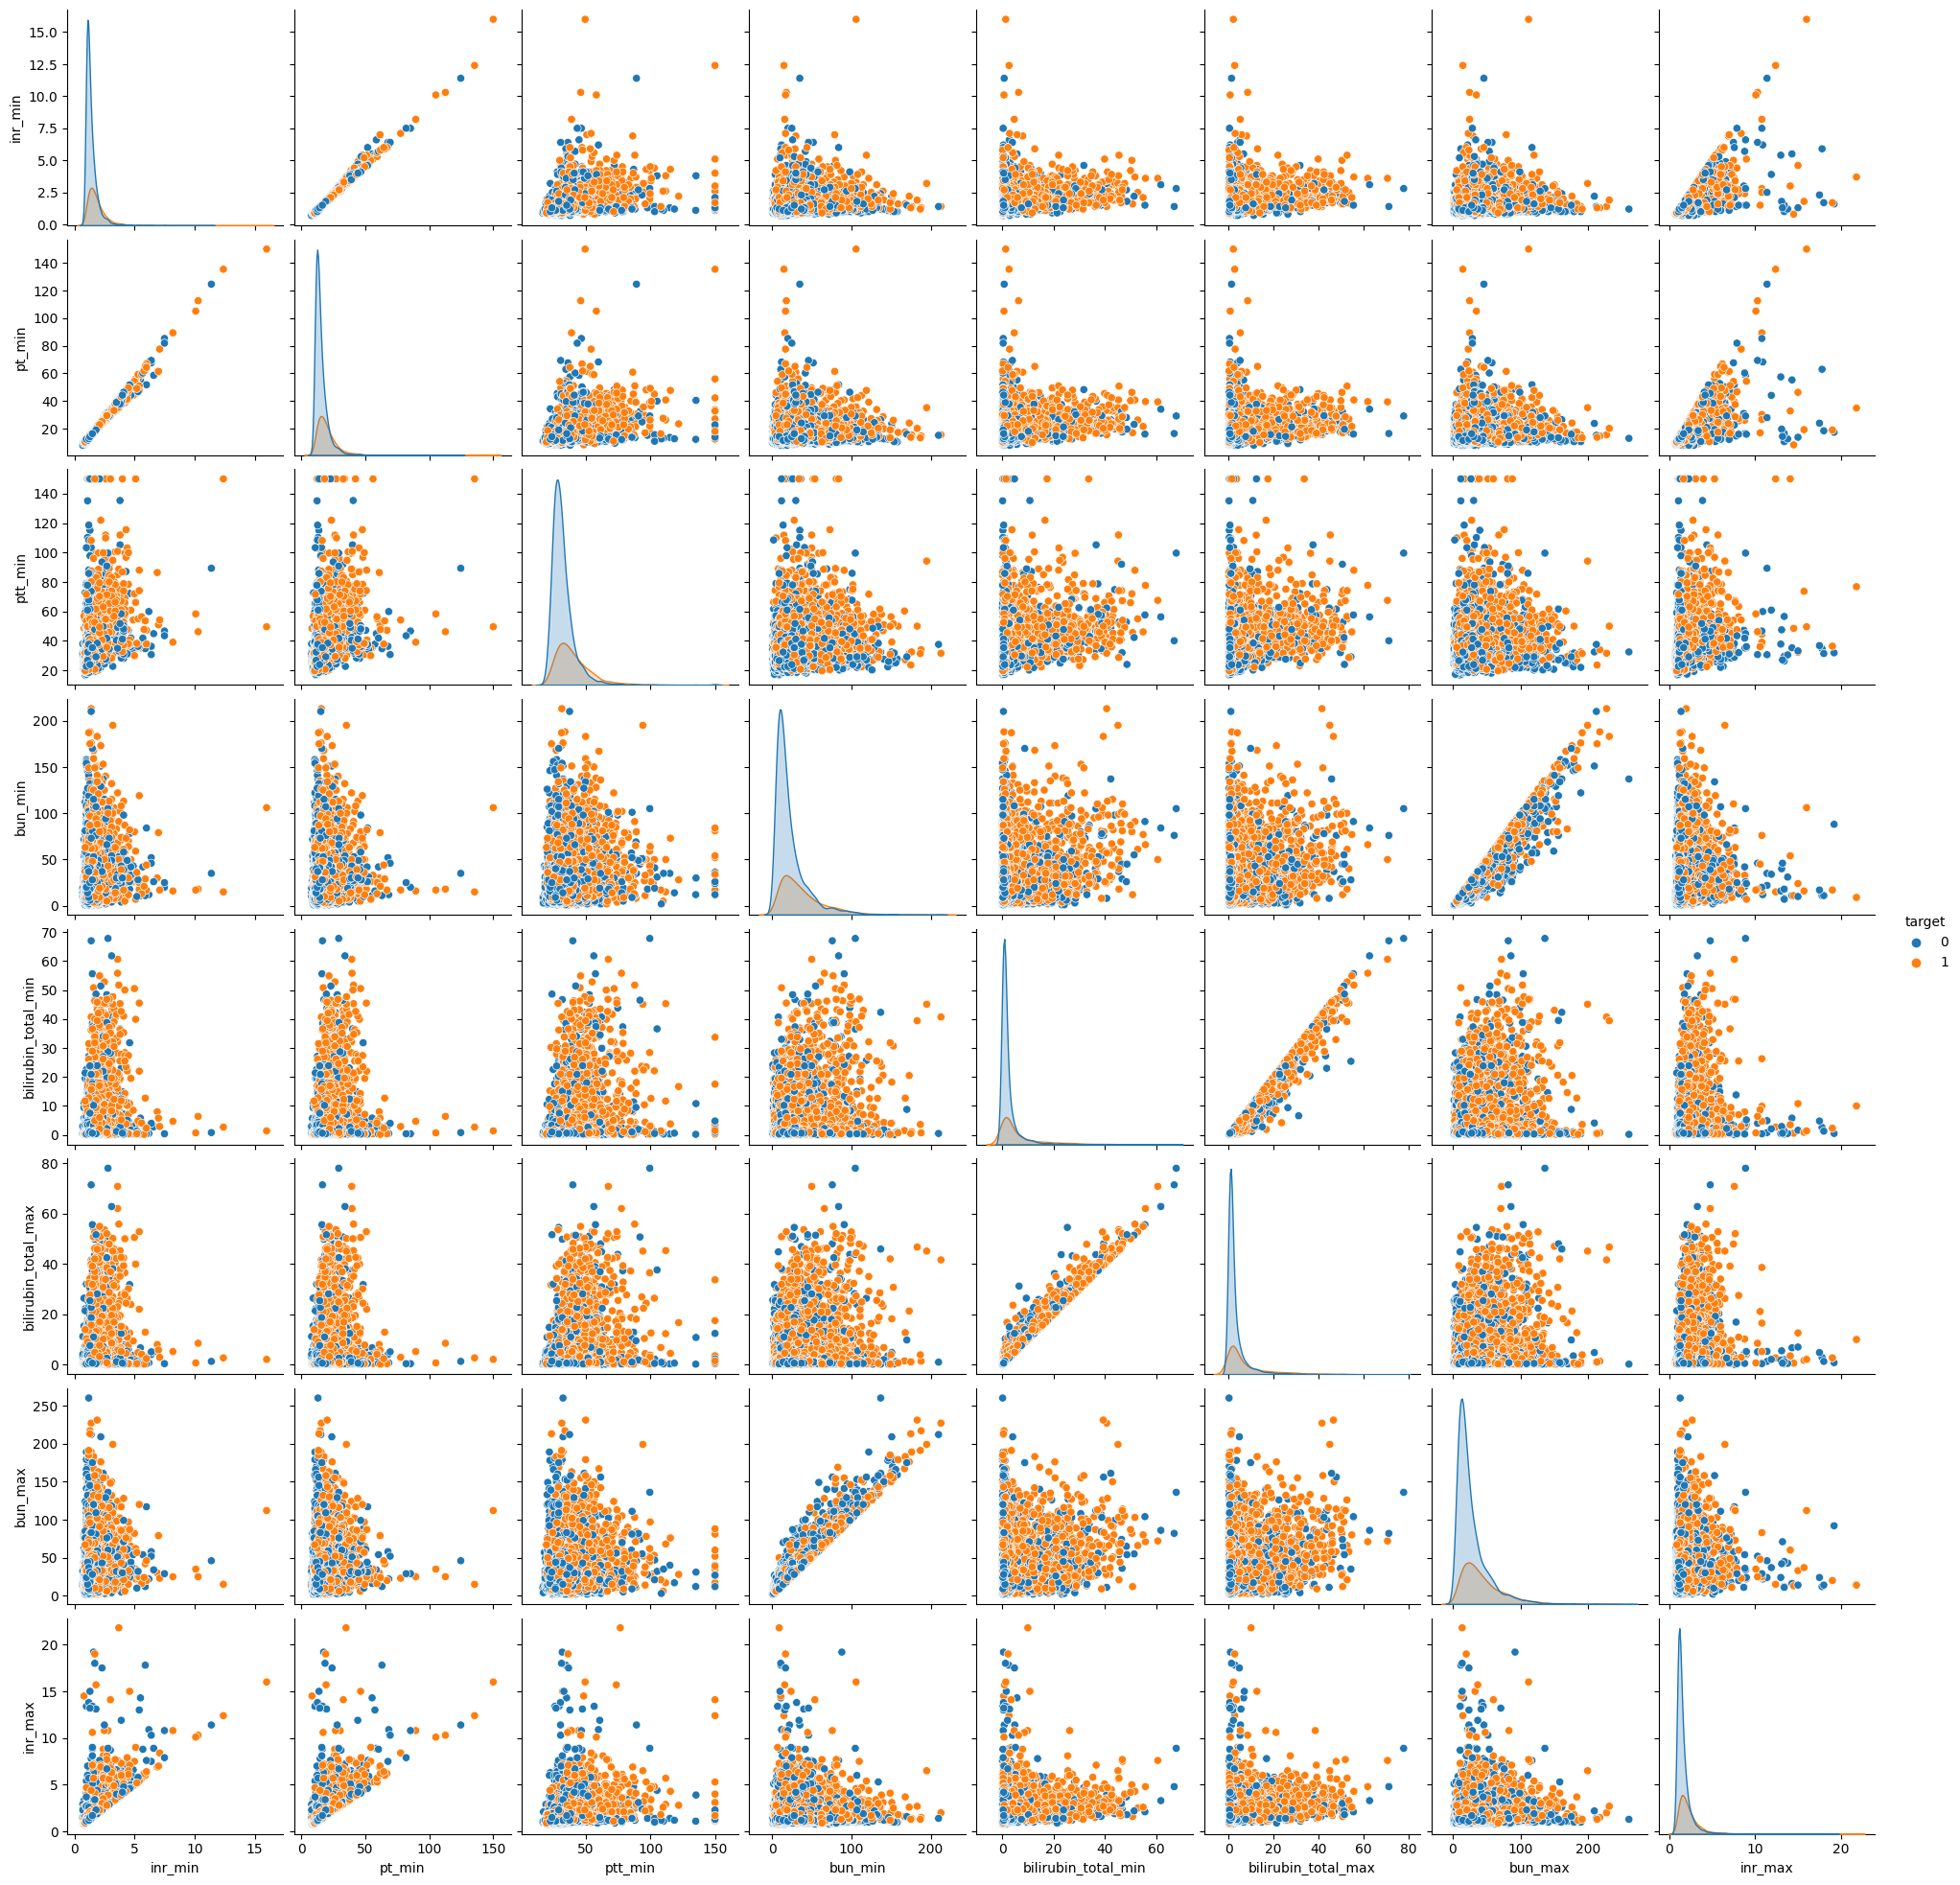

In [ ]:
# Plot the relationships betwen variables
sns.pairplot(pairwise_data, hue='target');

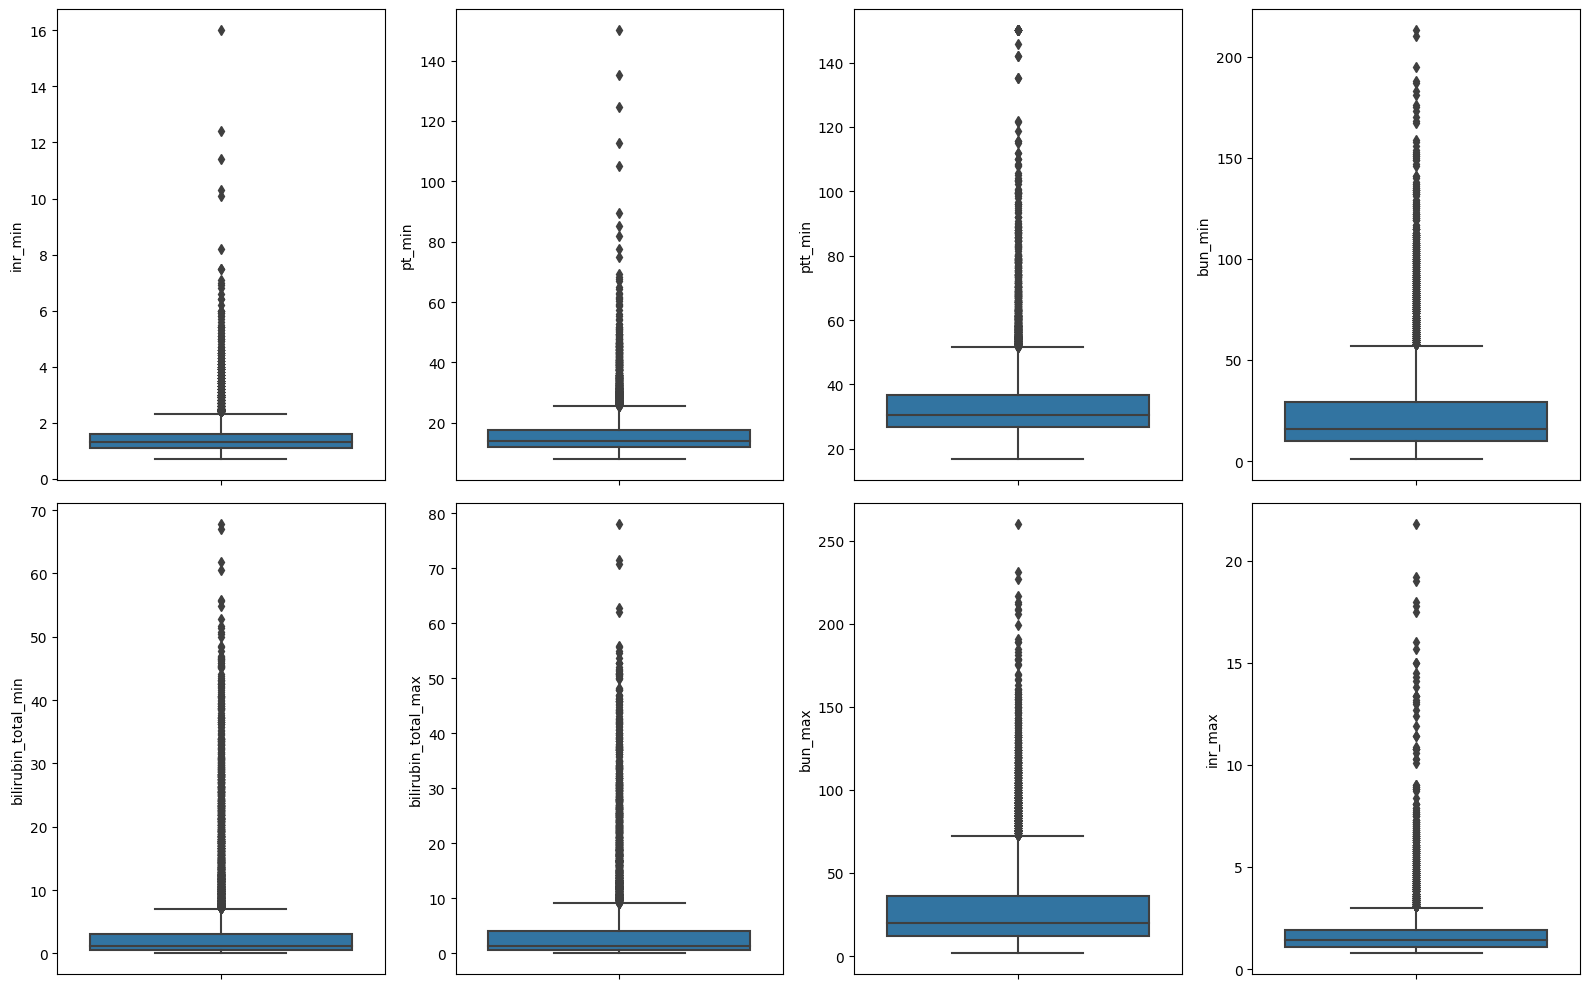

In [ ]:
plt.figure(figsize=(16,10))
for i,col in enumerate(key_cols):
    plt.subplot(2,4,i + 1)
    sns.boxplot(y=col, data=df_clean[key_cols])

plt.tight_layout()

plt.show()

## Categorical variables

In [ ]:
cat_cols = df_clean.select_dtypes(object)
cat_cols['target'] = df_clean['target']
cat_cols.columns

Index(['race', 'gender', 'target'], dtype='object')

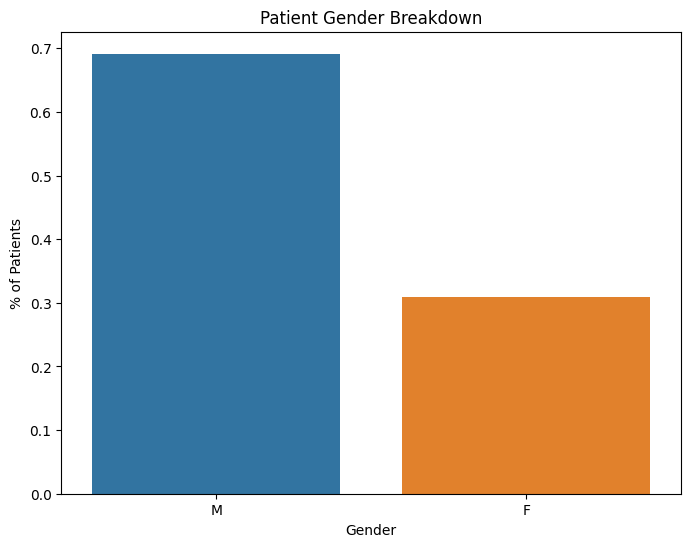

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
race_breakdown = cat_cols['gender'].value_counts(normalize=True).reset_index()
sns.barplot(race_breakdown, x='index', y='gender')

ax.set_title('Patient Gender Breakdown')
ax.set_xlabel('Gender')
ax.set_ylabel('% of Patients');

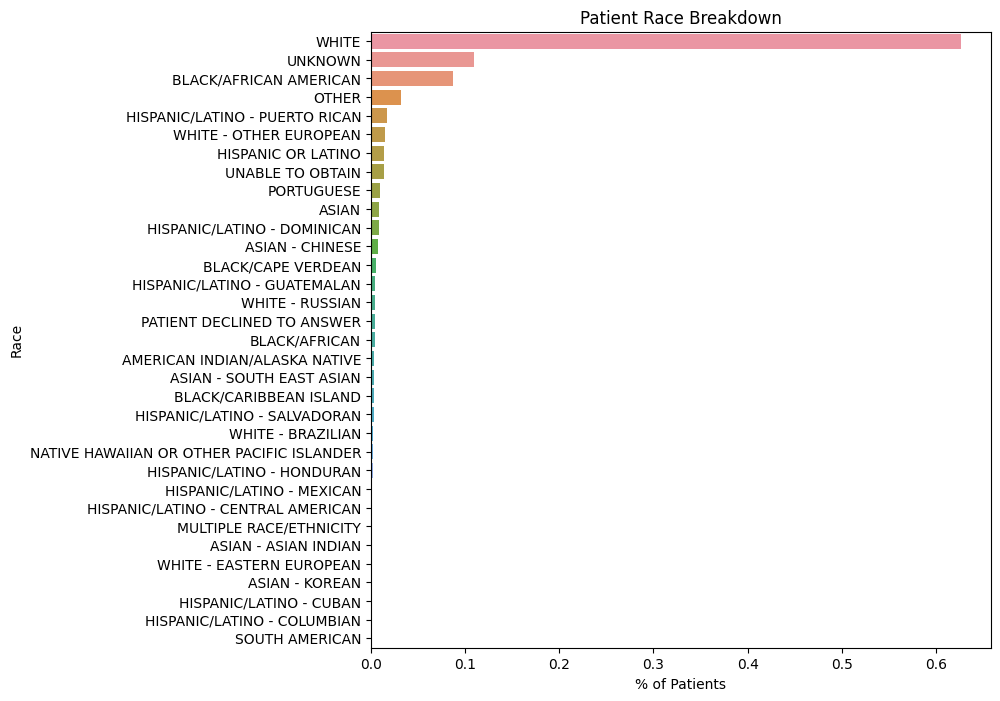

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
race_breakdown = cat_cols['race'].value_counts(normalize=True).reset_index()
sns.barplot(race_breakdown, x='race', y='index')

ax.set_title('Patient Race Breakdown')
ax.set_xlabel('% of Patients')
ax.set_ylabel('Race');

## Meld Scores

The MIMIC-IV project has [already calculated](https://github.com/MIT-LCP/mimic-code/blob/main/mimic-iv/concepts_postgres/organfailure/meld.sql) MELD scores. We can use these scores to set expectations for model performance

In [70]:
# MELD 3.0 survival chance calculation
def meld_survival_prediction(meld_score):
  return 1-0.946**math.exp(0.17698*meld_score - 3.56)

In [25]:
# MELD
def create_meld_groups(meld_score):
  if meld_score <= 9:
    return '≤9'
  elif meld_score <= 19:
    return '10-19'
  elif meld_score <= 29:
    return '20-29'
  elif meld_score <= 39:
    return '30-39'
  else:
    return '≥40'

In [71]:
df_meld = df.loc[:,['meld', 'target']]
df_meld['meld_group'] = df_meld.loc[:,'meld'].apply(create_meld_groups)
df_meld['target_pred'] = df_meld.loc[:,'meld'].apply(meld_survival_prediction)

In [72]:
df_meld.head()

meld  target meld_group  target_pred
0   8.0       0         ≤9     0.006483
1   7.0       0         ≤9     0.005434
2   6.0       0         ≤9     0.004555
3   6.0       0         ≤9     0.004555
4   9.0       0         ≤9     0.007733

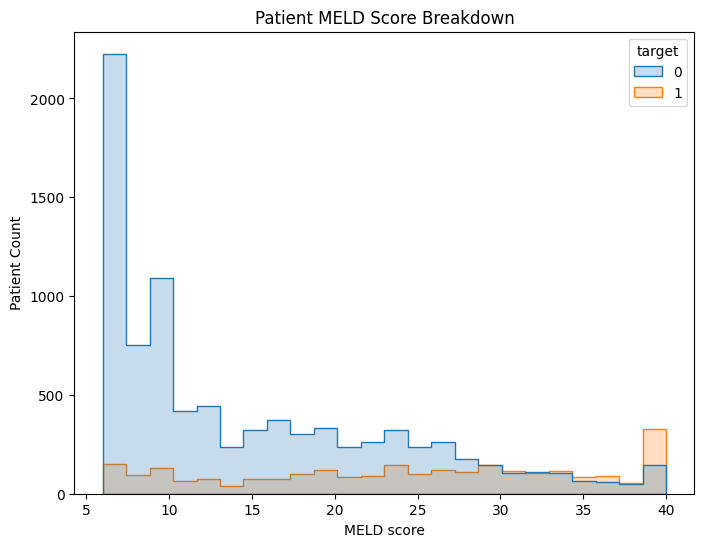

In [44]:
fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(df_meld, x='meld', hue='target', element='step')

ax.set_title('Patient MELD Score Breakdown')
ax.set_xlabel('MELD score')
ax.set_ylabel('Patient Count');

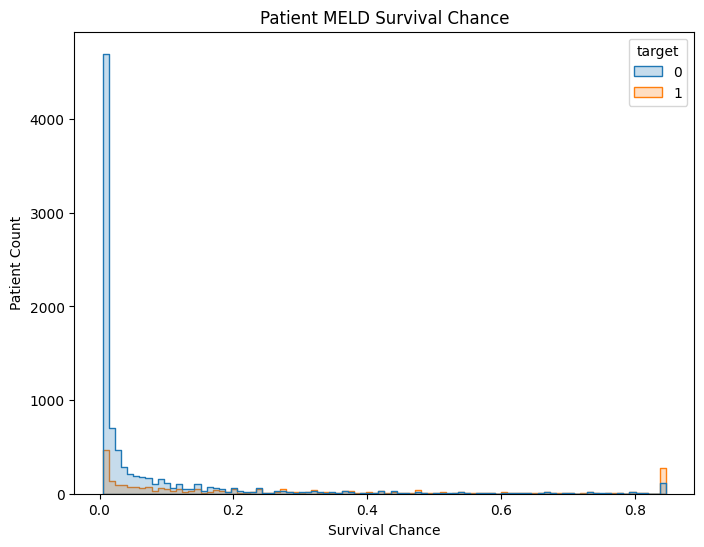

In [74]:
fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(df_meld, x='target_pred', hue='target', element="step")

ax.set_title('Patient MELD Survival Chance')
ax.set_xlabel('Survival Chance')
ax.set_ylabel('Patient Count');

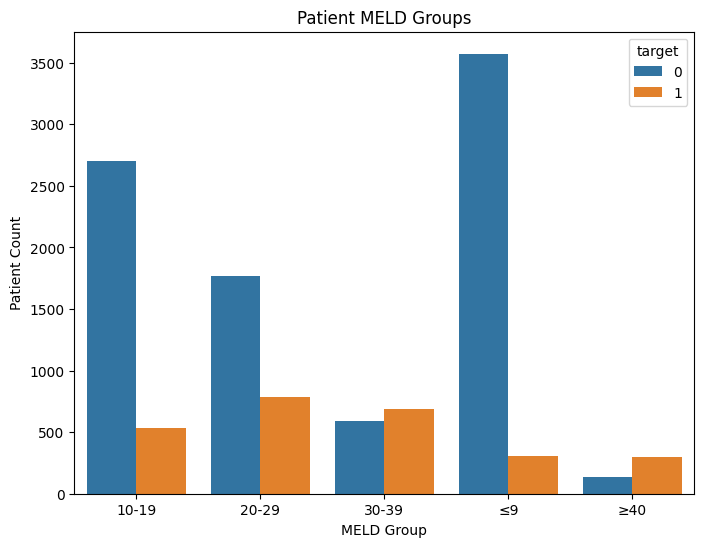

In [75]:
fig, ax = plt.subplots(figsize=(8,6))
meld_groups = df_meld.groupby(['meld_group', 'target']).count().reset_index()
sns.barplot(meld_groups, x='meld_group', y='target_pred', hue='target')

ax.set_title('Patient MELD Groups')
ax.set_xlabel('MELD Group')
ax.set_ylabel('Patient Count');

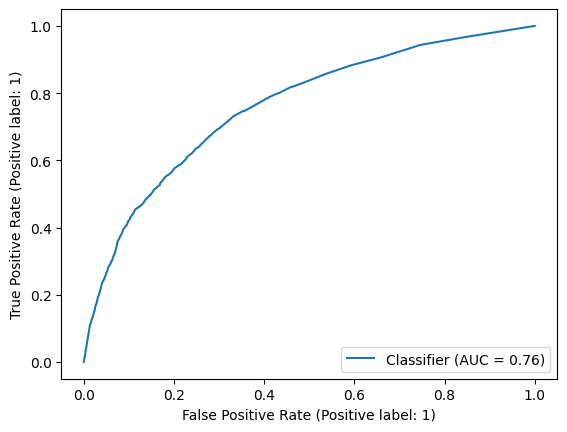

In [80]:
RocCurveDisplay.from_predictions(df_meld['target'],df_meld['target_pred'], pos_label=1);

Ok! So for this population MELD scores have a C-statistic of 0.76. We can use this as a baseline.

# Helper Functions

In [17]:
class ModelStorer():

    def __init__(self):
        self.models = {}
        self.model_scores = pd.DataFrame(columns=['model', 'dataset', 'metric', 'value'])
        self.model_cv_results = pd.DataFrame(columns=['model', 'CV Results'])

    def add_model(self, model):
        self.models[model.model_name] = model
        self.model_scores = self.model_scores.append(model.model_scores)
        self.model_cv_results = self.model_cv_results.append(model.cv_summary)

    def validate_models(self):
        for name, model in self.models.items():
            model.score_model_validate()

            model_data = model.model_scores
            val_filter = model_data['dataset']=='validate'
            self.model_scores = self.model_scores.append(model_data[val_filter])

    def print_scores(self, metric='accuracy_score'):
        display(self.model_scores[ self.model_scores['metric'] == metric])

    def return_scores(self):
        return self.model_scores

    def plot_models_roc_curves(self, dataset='train'):
        fig, ax = plt.subplots(figsize=(6,6))
        for name, model in self.models.items():
            model.plot_model_roc_curve(ax, dataset)
        fig.suptitle(f'Model ROC Curves for {dataset.title()} Data')
        plt.show()

    def plot_models_scores(self, dataset='train'):
        data = self.model_scores
        g = sns.FacetGrid(data[data['dataset']==dataset], col="metric", col_wrap=2, height=4)
        g.map(sns.barplot, "value", "model", order=list(self.models.keys()))
        g.fig.subplots_adjust(top=0.9)
        g.fig.suptitle(f'Model Metrics for {dataset.title()} Data')

    def show_cv_results(self):
        display(self.model_cv_results)

    def plot_models_confusion_matricies(self, dataset='train'):
        num_models = len(self.models.keys())

        nrows = 2
        ncols = math.ceil(num_models/nrows)

        fig, axes = plt.subplots(
                        nrows=nrows,
                        ncols=ncols,
                        figsize=(ncols*3, nrows*3)
        )
        fig.suptitle(f'Model Confusion Matricies for {dataset.title()} Data')

        # Turn off all the axes in case there is nothing to plot
        [ax.axis('off') for ax in axes.ravel()]


        for i, (name, model) in enumerate(self.models.items()):
            # Logic for making rows and columns for matrices
            row = i // ncols
            col = i % ncols
            ax = axes[row, col]
            ax.set_title(name)
            ax.set_axis_on() # turn back on the axis
            model.plot_model_confusion_matrix(ax, dataset)

        plt.tight_layout()

    def clear_models(self):
        self.models = {}

    def remove_model(self, model_name):
        del self.models[model_name]

In [18]:
class SaveModel():
     def __init__(self,
                    model,
                    X_train,
                    y_train,
                    X_train_test,
                    y_train_test,
                    X_test,
                    y_test,
                    X_val,
                    y_val,
                    model_name='None'):

               self.model = model
               self.model_name = model_name
               self.X_train = X_train
               self.X_test = X_test
               self.y_train = y_train
               self.y_test = y_test
               self.X_train_test = X_train_test
               self.y_train_test = y_train_test
               self.X_val = X_val
               self.y_val = y_val

     def info(self):
          print(f'-------{self.model_name} Information-------')
          print(f'Model: {self.model}')

     def score_model_train_test(self):
          # Fit on training data
          self.model.fit(self.X_train, self.y_train)

          # Predict on training and test data
          self.ytrain_hat = self.model.predict(self.X_train)
          self.ytrain_prob = self.model.predict_proba(self.X_train)
          self.ytest_hat = self.model.predict(self.X_test)
          self.ytest_prob = self.model.predict_proba(self.X_test)

          # cross validation
          kf = KFold(n_splits=5, random_state=42, shuffle=True)
          self.cv_results = cross_val_score(self.model, self.X_train, y_train, cv=kf)
          self.cv_mean = np.mean(self.cv_results)
          self.cv_median = np.median(self.cv_results)
          self.cv_std = np.std(self.cv_results)
          cv_sum = f'{self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy'
          self.cv_summary = pd.DataFrame([[self.model_name, cv_sum]], columns=['model', 'CV Results'])


          # Create the model scores on train and test data
          self.model_scores = pd.DataFrame([
                         [self.model_name, 'train', 'accuracy_score', accuracy_score(self.y_train, self.ytrain_hat)],
                         [self.model_name, 'train', 'recall_score', recall_score(self.y_train, self.ytrain_hat)],
                         [self.model_name, 'train', 'precision_score', precision_score(self.y_train, self.ytrain_hat)],
                         [self.model_name, 'train', 'f1_score', f1_score(self.y_train, self.ytrain_hat)],
                         [self.model_name, 'test', 'accuracy_score', accuracy_score(self.y_test, self.ytest_hat)],
                         [self.model_name, 'test', 'recall_score', recall_score(self.y_test, self.ytest_hat)],
                         [self.model_name, 'test', 'precision_score', precision_score(self.y_test, self.ytest_hat)],
                         [self.model_name, 'test', 'f1_score', f1_score(self.y_test, self.ytest_hat)]
                         ],
                         columns=['model', 'dataset', 'metric', 'value'])

     def score_model_validate(self):
          # Train on the full dataset
          self.model.fit(self.X_train_test, self.y_train_test)

          # Predict results for the validate dataset
          self.yval_hat = self.model.predict(self.X_val)
          self.yval_prob = self.model.predict_proba(self.X_val)

          # Add the scores to the model scores
          self.model_scores = self.model_scores.append(
               pd.DataFrame([
                         [self.model_name, 'validate', 'accuracy_score', accuracy_score(self.y_val, self.yval_hat)],
                         [self.model_name, 'validate', 'recall_score', recall_score(self.y_val, self.yval_hat)],
                         [self.model_name, 'validate', 'precision_score', precision_score(self.y_val, self.yval_hat)],
                         [self.model_name, 'validate', 'f1_score', f1_score(self.y_val, self.yval_hat)],
                         ],
                         columns=['model', 'dataset', 'metric', 'value'])
          )

     def get_data(self, dataset, data_type):
          if dataset == 'train':
               y = list(self.y_train)
               y_hat = self.ytrain_hat if data_type == 'pred' else self.ytrain_prob[:,1]
          elif dataset == 'test':
               y = list(self.y_test)
               y_hat = self.ytest_hat if data_type == 'pred' else self.ytest_prob[:,1]
          elif dataset == 'validate':
               y = list(self.y_val)
               y_hat = self.yval_hat if data_type == 'pred' else self.yval_prob[:,1]

          return y, y_hat

     def plot_model_roc_curve(self, ax, dataset='train'):
          (y, y_hat) = self.get_data(dataset, 'proba')

          RocCurveDisplay.from_predictions(y, y_hat, ax=ax, name=self.model_name)

     def plot_model_confusion_matrix(self, ax, dataset='train'):
          (y, y_hat) = self.get_data(dataset, 'pred')

          cm_display = ConfusionMatrixDisplay.from_predictions(y,
                                             y_hat,
                                             normalize='true',
                                             cmap='plasma',
                                             display_labels=['Survived', 'Perished'],
                                             ax=ax)
          cm_display.im_.set_clim(0, 1)

# Modeling

In [15]:
def train_test_val_split(X,y):
  X_train_test, X_val, y_train_test, y_val = train_test_split(X, y, random_state=42)
  X_train, X_test, y_train, y_test = train_test_split(X_train_test, y_train_test, random_state=42)
  print('----------X Information----------')
  print(f'shape X_train = {X_train.shape}')
  print(f'shape X_test = {X_test.shape}')
  print(f'shape X_train_test = {X_train_test.shape}')
  print(f'shape X_val = {X_val.shape}')
  print('----------y Information----------')
  print('y_train value counts')
  print(y_train.value_counts())
  print('--------------------')
  print('y_test value counts')
  print(y_test.value_counts())
  print('--------------------')
  print('y_train_test value counts')
  print(y_train_test.value_counts())
  print('--------------------')
  print('y_val value counts')
  print(y_val.value_counts())
  return X_train, X_test, X_train_test, X_val, y_train, y_test, y_train_test, y_val


In [16]:
X = df_clean.drop('target', axis=1)
y = df_clean['target']
X_train, X_test, X_train_test, X_val, y_train, y_test, y_train_test, y_val = train_test_val_split(X, y)

----------X Information----------
shape X_train = (6401, 53)
shape X_test = (2134, 53)
shape X_train_test = (8535, 53)
shape X_val = (2846, 53)
----------y Information----------
y_train value counts
0    4909
1    1492
Name: target, dtype: Int64
--------------------
y_test value counts
0    1625
1     509
Name: target, dtype: Int64
--------------------
y_train_test value counts
0    6534
1    2001
Name: target, dtype: Int64
--------------------
y_val value counts
0    2232
1     614
Name: target, dtype: Int64


## Dummy Model & Baseline Models

In [21]:
# Create the subpipe for the numeric variables
subpipe_numerics = Pipeline(steps = [
    ('num_impute', SimpleImputer(strategy='median')),
    ('ss', StandardScaler())
])

# Create the subpipe for the one-hot encoded variables
subpipe_cat = Pipeline(steps=[
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'))
])

In [22]:
# Create the column transformer
CT = ColumnTransformer(transformers=[
    ('subpipe_num', subpipe_numerics, selector(dtype_include=np.number)),
    ('subpipe_cat', subpipe_cat, selector(dtype_include=object))
], remainder='passthrough')

In [19]:
# Instantiate our model storage
model_dict = ModelStorer()

In [ ]:
# Create some baseline models
dum_model = DummyClassifier(strategy='most_frequent')
lr_model = LogisticRegression()
tree_model = DecisionTreeClassifier()
model_list = [('dummy',dum_model), ('logreg',lr_model), ('dtc',tree_model)]

dummy_models = {}

for name, model in model_list:

    # Create baseline pipelines
    loop_model_pipe = ImPipeline(steps=[
        ('ct', CT),
        ('sm',SMOTE(random_state=42)),
        (name, model)
    ])

    # Create a saved model object
    loop_model_results = SaveModel(
        model=loop_model_pipe,
        model_name=name,
        X_train=X_train,
        y_train=y_train,
        X_train_test=X_train_test,
        y_train_test=y_train_test,
        X_test=X_test,
        y_test=y_test,
        X_val=X_val,
        y_val=y_val,
        )

    # Fit and score on train and test data
    loop_model_results.score_model_train_test()

    # Add the model to the dictionary
    model_dict.add_model(loop_model_results)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-31-1b579c8aabfd>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_scores = self.model_scores.append(model.model_scores)
<ipython-input-31-1b579c8aabfd>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_

In [ ]:
model_dict.models

{'dummy': <__main__.SaveModel at 0x7fc2012a63e0>,
 'logreg': <__main__.SaveModel at 0x7fc2012a6320>,
 'dtc': <__main__.SaveModel at 0x7fc2012a6710>}

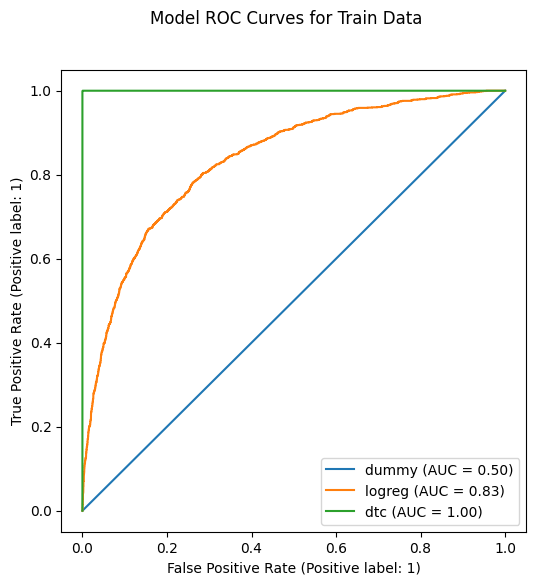

In [ ]:
model_dict.plot_models_roc_curves('train')

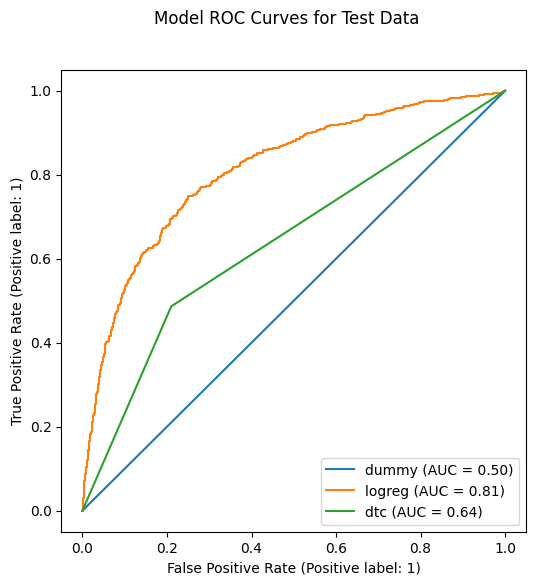

In [ ]:
model_dict.plot_models_roc_curves('test')

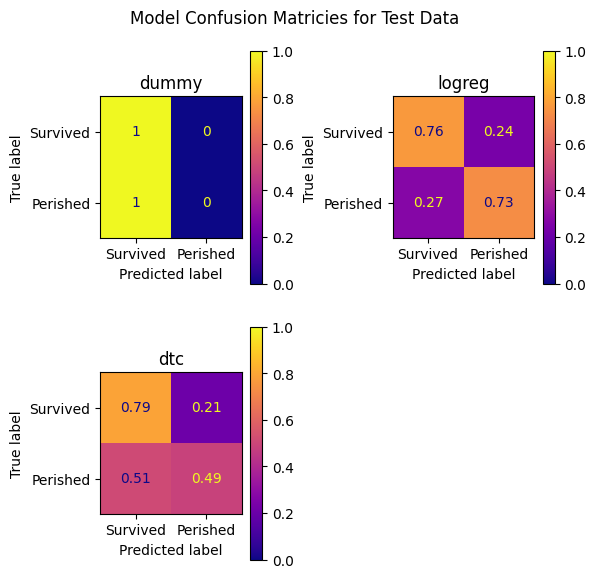

In [ ]:
model_dict.plot_models_confusion_matricies('test')

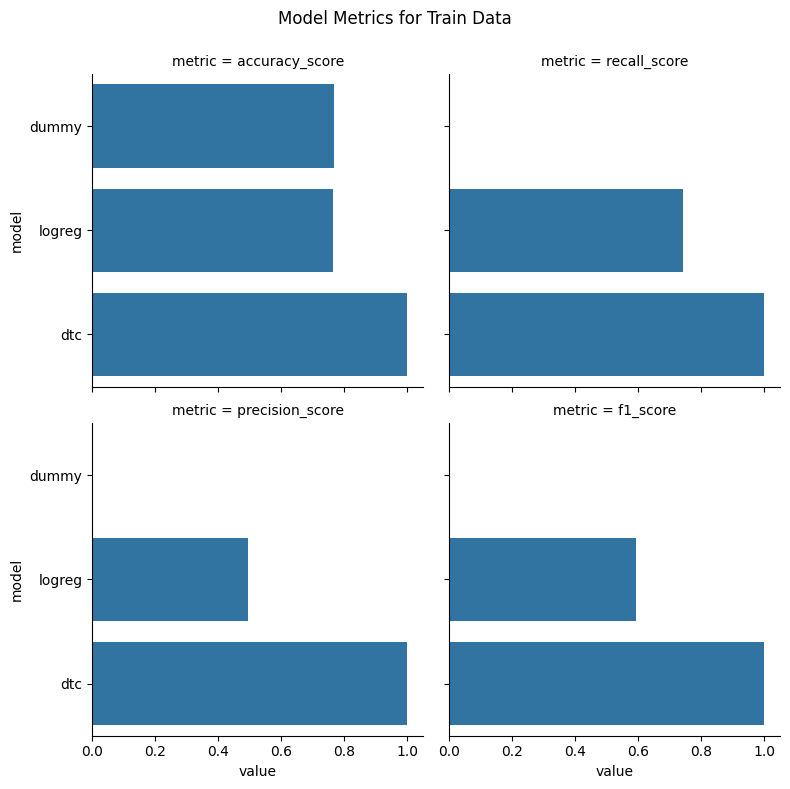

In [ ]:
model_dict.plot_models_scores('train')

In [ ]:
model_dict.show_cv_results()

model                  CV Results
0   dummy  0.76691 ± 0.00614 accuracy
0  logreg  0.76051 ± 0.01188 accuracy
0     dtc  0.73051 ± 0.00637 accuracy

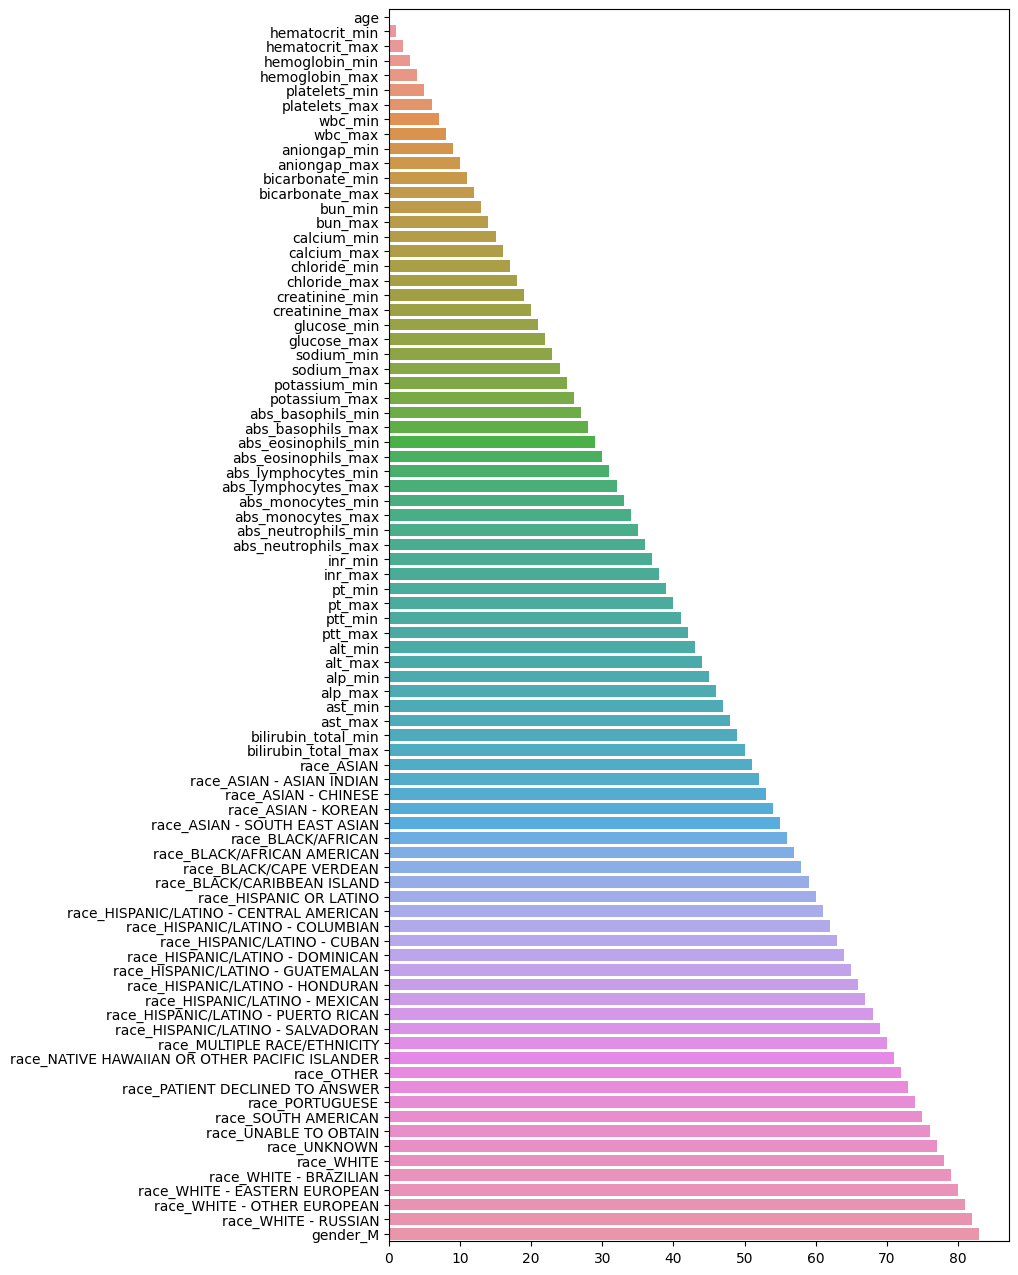

In [ ]:
y = list(model_dict.models['logreg'].model.named_steps.ct.get_feature_names_out())
y = [val.split("__")[1] for val in y]

x = list(pd.DataFrame(model_dict.models['logreg'].model.named_steps.logreg.coef_).astype(float))

fig, ax = plt.subplots(figsize=(8,16))
sns.barplot(x=x,y=y, orient='h', ax=ax);

## XGBoost

In [ ]:
grad_boost = XGBClassifier(random_state=42, objective='binary:logistic')

# Create pipelines
xgb_pipe = ImPipeline(steps=[
    ('ct', CT),
    ('sm',SMOTE(random_state=42)),
    ('xgb', grad_boost)
])

# Create a saved model object
xgb_pipe_results = SaveModel(
    model=xgb_pipe,
    model_name='xgb',
    X_train=X_train,
    y_train=y_train,
    X_train_test=X_train_test,
    y_train_test=y_train_test,
    X_test=X_test,
    y_test=y_test,
    X_val=X_val,
    y_val=y_val,
    )

# Fit and score on train and test data
xgb_pipe_results.score_model_train_test()

# Add the model to the dictionary
model_dict.add_model(xgb_pipe_results)

<ipython-input-155-1b579c8aabfd>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_scores = self.model_scores.append(model.model_scores)
<ipython-input-155-1b579c8aabfd>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_cv_results = self.model_cv_results.append(model.cv_summary)


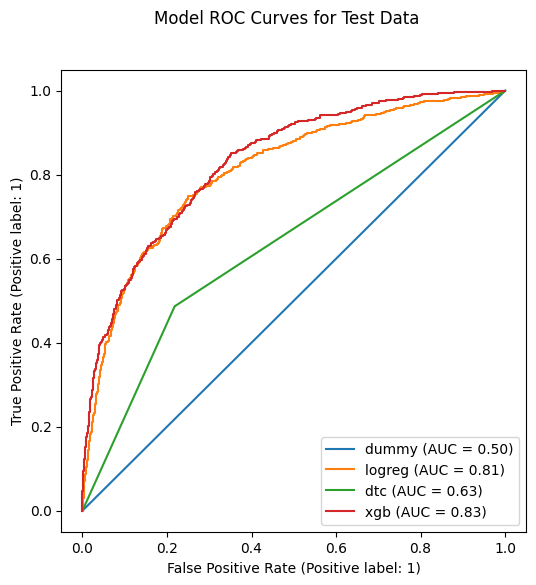

In [ ]:
model_dict.plot_models_roc_curves('test')

In [ ]:
model_dict.show_cv_results()

model                  CV Results
0   dummy  0.76691 ± 0.00614 accuracy
0  logreg  0.76051 ± 0.01188 accuracy
0     dtc  0.73411 ± 0.00779 accuracy
0     xgb  0.81441 ± 0.00582 accuracy

## Reducing Dimmensionality

### Select From Model

In [ ]:
grad_boost_sfm = XGBClassifier(random_state=42, objective='binary:logistic')

# Create the subpipe for the numeric variables
subpipe_numerics_sfm = Pipeline(steps = [
    ('num_impute', SimpleImputer(strategy='median')),
    ('ss', StandardScaler()),
    ('sfm',SelectFromModel(XGBClassifier(random_state=42, objective='binary:logistic'), max_features=10))
])

# Create the subpipe for the one-hot encoded variables
subpipe_cat_sfm = Pipeline(steps=[
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'))
])

# Create the column transformer
CT2 = ColumnTransformer(transformers=[
    ('subpipe_num', subpipe_numerics_sfm, selector(dtype_include=np.number)),
    ('subpipe_cat', subpipe_cat_sfm, selector(dtype_include=object))
], remainder='passthrough')

xgb_sfm_pipe = ImPipeline(steps=[
        ('ct', CT2),
        ('sm',SMOTE(random_state=42)),
        ('xgb',grad_boost_sfm)
    ])

# Create a saved model object
xgb_sfm_results = SaveModel(
    model=xgb_sfm_pipe,
    model_name='XGB_SFM',
    X_train=X_train,
    y_train=y_train,
    X_train_test=X_train_test,
    y_train_test=y_train_test,
    X_test=X_test,
    y_test=y_test,
    X_val=X_val,
    y_val=y_val,
    )

# Fit and score on train and test data
xgb_sfm_results.score_model_train_test()

# Add the model to our list of modesl
model_dict.add_model(xgb_sfm_results)

<ipython-input-155-1b579c8aabfd>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_scores = self.model_scores.append(model.model_scores)
<ipython-input-155-1b579c8aabfd>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_cv_results = self.model_cv_results.append(model.cv_summary)


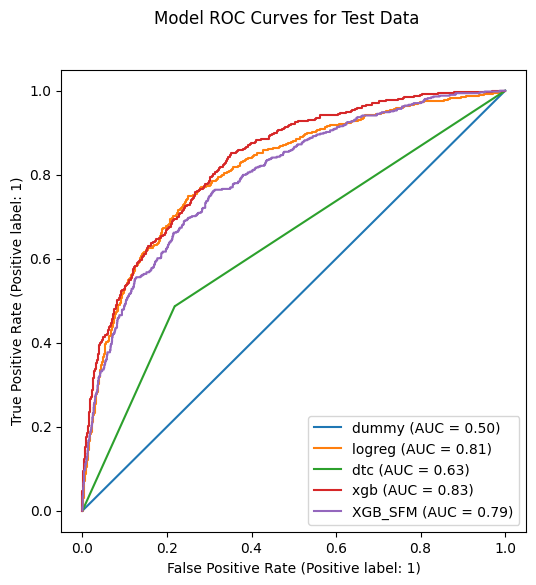

In [ ]:
model_dict.plot_models_roc_curves('test')

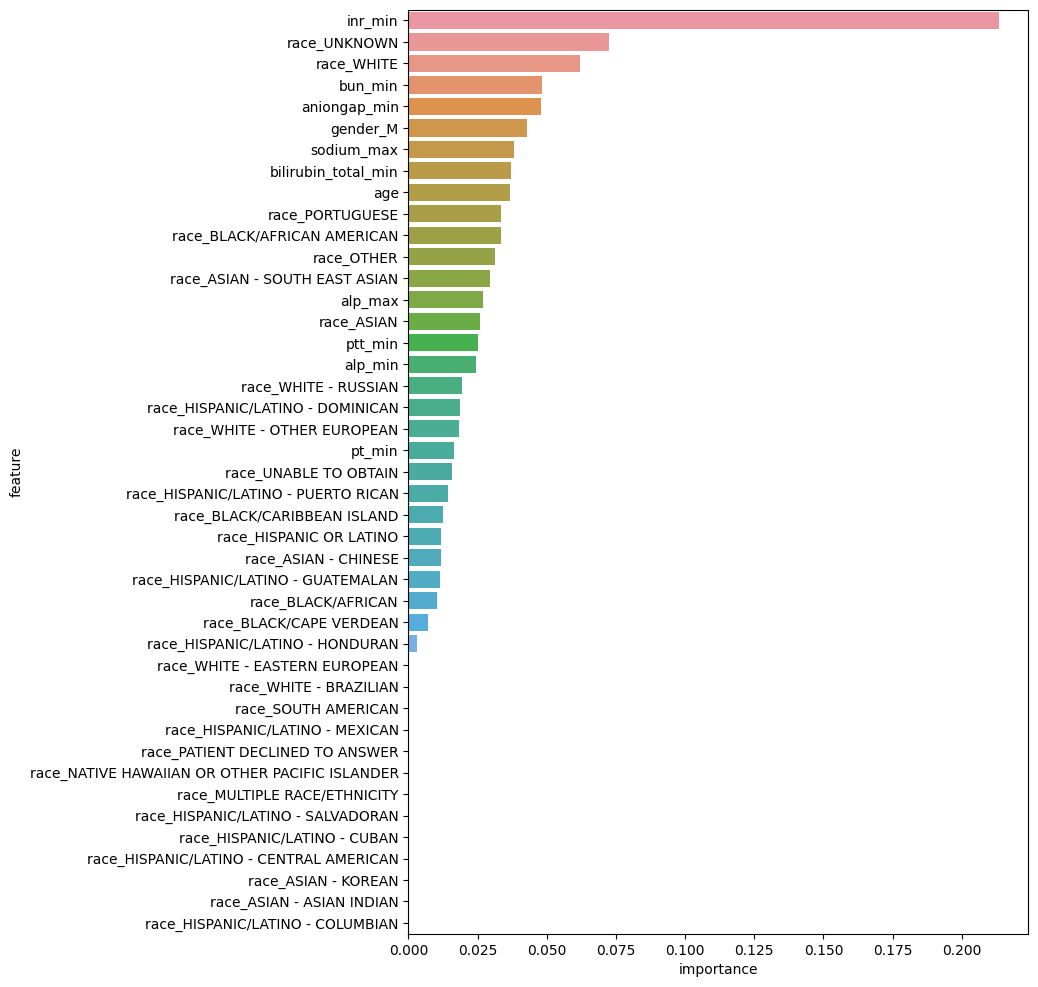

In [ ]:
xgb_features = pd.DataFrame()

y = model_dict.models['XGB_SFM'].model.named_steps.ct.get_feature_names_out()
xgb_features['feature'] = [val.split("__")[1] for val in y]

xgb_features['importance'] = pd.DataFrame(model_dict.models['XGB_SFM'].model.named_steps.xgb.feature_importances_).astype(float)[0]

xgb_features = xgb_features.sort_values(by='importance', ascending=False)

fig, ax = plt.subplots(figsize=(8,12))
sns.barplot(data=xgb_features, y='feature', x='importance', ax=ax);

In [ ]:
model_dict.show_cv_results()

model                  CV Results
0    dummy  0.76691 ± 0.00614 accuracy
0   logreg  0.76051 ± 0.01188 accuracy
0      dtc  0.73411 ± 0.00779 accuracy
0      xgb  0.81441 ± 0.00582 accuracy
0  XGB_SFM  0.79691 ± 0.00645 accuracy

### Principal Component Analysis

In [ ]:
## PCA
grad_boost_pca = XGBClassifier(random_state=42, objective='binary:logistic')

xgb_pca_pipe = ImPipeline(steps=[
        ('ct', CT),
        ('pca', PCA(n_components=10)),
        ('sm',SMOTE(random_state=42)),
        ('xgb',grad_boost_pca)
    ])

# Create a saved model object
xgb_pca_results = SaveModel(
    model=xgb_pca_pipe,
    model_name='XGB_PCA',
    X_train=X_train,
    y_train=y_train,
    X_train_test=X_train_test,
    y_train_test=y_train_test,
    X_test=X_test,
    y_test=y_test,
    X_val=X_val,
    y_val=y_val,
    )

# Fit and score on train and test data
xgb_pca_results.score_model_train_test()

# Add the model to our list of modesl
model_dict.add_model(xgb_pca_results)

<ipython-input-155-1b579c8aabfd>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_scores = self.model_scores.append(model.model_scores)
<ipython-input-155-1b579c8aabfd>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_cv_results = self.model_cv_results.append(model.cv_summary)


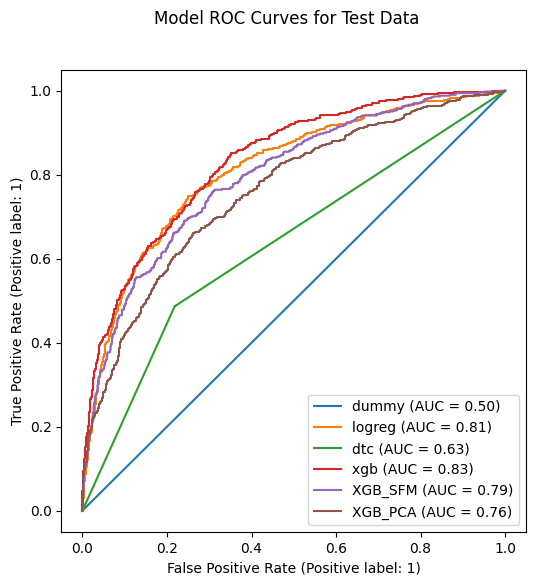

In [ ]:
model_dict.plot_models_roc_curves('test')

In [ ]:
model_dict.show_cv_results()

model                  CV Results
0    dummy  0.76691 ± 0.00614 accuracy
0   logreg  0.76051 ± 0.01188 accuracy
0      dtc  0.73411 ± 0.00779 accuracy
0      xgb  0.81441 ± 0.00582 accuracy
0  XGB_SFM  0.79691 ± 0.00645 accuracy
0  XGB_PCA  0.75442 ± 0.01168 accuracy

## Outlier Handling

In [ ]:
grad_boost_outlier = XGBClassifier(random_state=42, objective='binary:logistic')

# Create the subpipe for the numeric variables
subpipe_numerics_out = Pipeline(steps = [
    ('num_impute', SimpleImputer(strategy='median')),
    ('ss', StandardScaler()),
    ('sfm',SelectFromModel(XGBClassifier(random_state=42, objective='binary:logistic'), max_features=10))
])

# Create the subpipe for the one-hot encoded variables
subpipe_cat_out = Pipeline(steps=[
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'))
])

# Create the column transformer
CT3 = ColumnTransformer(transformers=[
    ('subpipe_num', subpipe_numerics_out, selector(dtype_include=np.number)),
    ('subpipe_cat', subpipe_cat_out, selector(dtype_include=object))
], remainder='passthrough')

# Create the outlier handler
outlier_detector = IsolationForest(random_state = 42)
enricher = FeatureUnion([
  ("identity", IdentityTransformer()),
  ("outlier_detector", EstimatorTransformer(outlier_detector, predict_func = "decision_function"))
])

xgb_out_pipe = ImPipeline(steps=[
        ('ct', CT3),
        ("enricher", enricher),
        ('sm',SMOTE(random_state=42)),
        ('xgb',grad_boost_outlier)
    ])

# Create a saved model object
xgb_out_results = SaveModel(
    model=xgb_out_pipe,
    model_name='XGB_OUT',
    X_train=X_train,
    y_train=y_train,
    X_train_test=X_train_test,
    y_train_test=y_train_test,
    X_test=X_test,
    y_test=y_test,
    X_val=X_val,
    y_val=y_val,
    )

# Fit and score on train and test data
xgb_out_results.score_model_train_test()

# Add the model to our list of modesl
model_dict.add_model(xgb_out_results)

<ipython-input-155-1b579c8aabfd>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_scores = self.model_scores.append(model.model_scores)
<ipython-input-155-1b579c8aabfd>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_cv_results = self.model_cv_results.append(model.cv_summary)


In [ ]:
model_dict.show_cv_results()

model                  CV Results
0    dummy  0.76691 ± 0.00614 accuracy
0   logreg  0.76051 ± 0.01188 accuracy
0      dtc  0.73411 ± 0.00779 accuracy
0      xgb  0.81441 ± 0.00582 accuracy
0  XGB_SFM  0.79691 ± 0.00645 accuracy
0  XGB_PCA  0.75442 ± 0.01168 accuracy
0  XGB_OUT  0.79566 ± 0.00424 accuracy

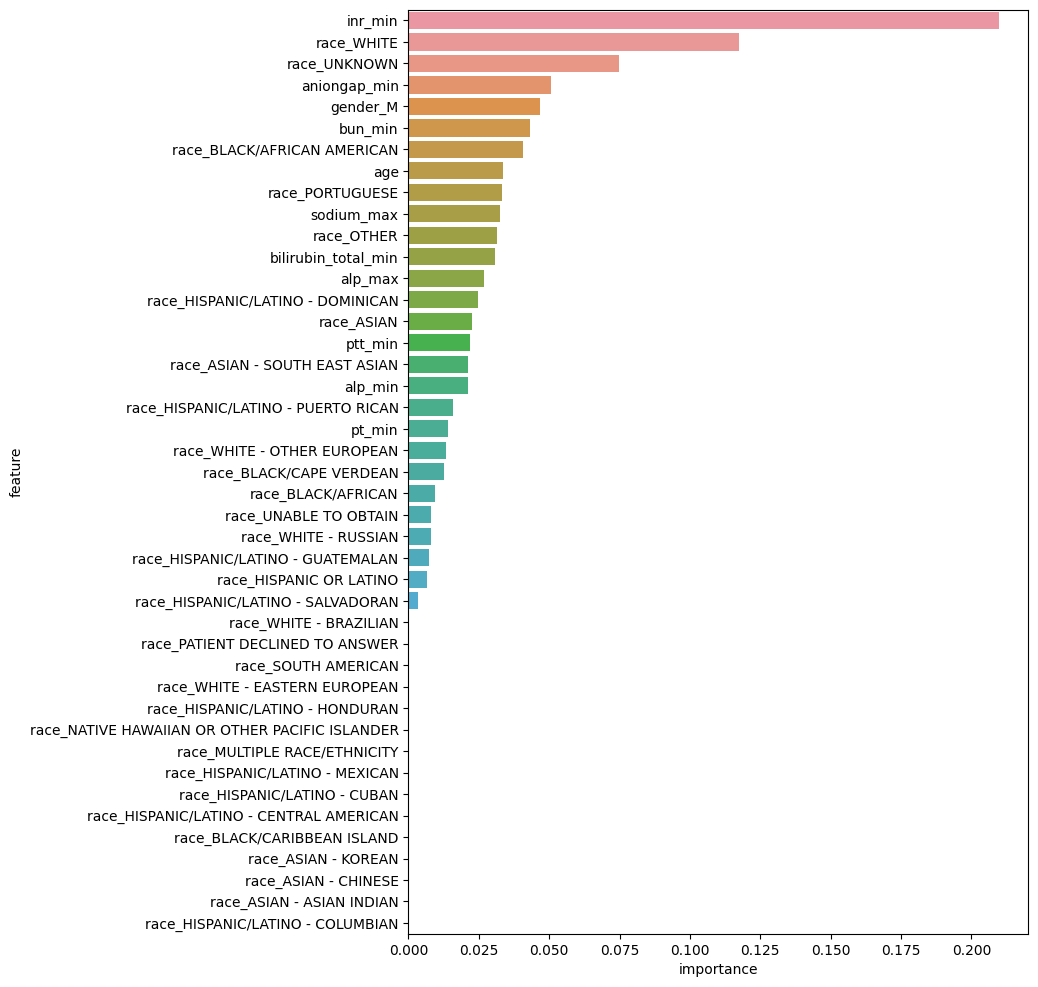

In [ ]:
xgb_features = pd.DataFrame()

y = model_dict.models['XGB_OUT'].model.named_steps.ct.get_feature_names_out()
xgb_features['feature'] = [val.split("__")[1] for val in y]

xgb_features['importance'] = pd.DataFrame(model_dict.models['XGB_OUT'].model.named_steps.xgb.feature_importances_).astype(float)[0]

xgb_features = xgb_features.sort_values(by='importance', ascending=False)

fig, ax = plt.subplots(figsize=(8,12))
sns.barplot(data=xgb_features, y='feature', x='importance', ax=ax);

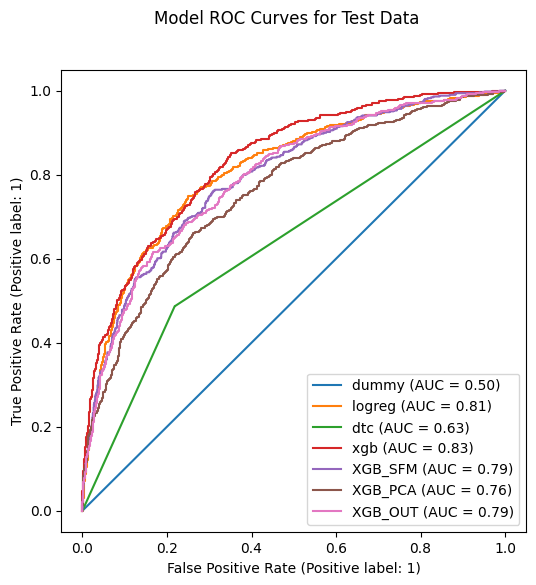

In [ ]:
model_dict.plot_models_roc_curves('test')

## KNN

In [ ]:
k_scores_train = {}
k_scores_test = {}

for k in range(1, 40):
  knn = KNeighborsClassifier(n_neighbors=k)

  knn_pipe = ImPipeline(steps=[
        ('ct', CT3),
        ("enricher", enricher),
        ('sm',SMOTE(random_state=42)),
        ('knn',knn)
    ])

  knn_pipe.fit(X_train, y_train)

  y_pred_train = knn_pipe.predict(X_train)
  y_pred_test = knn_pipe.predict(X_test)

  k_scores_train[k] = accuracy_score(y_train, y_pred_train)
  k_scores_test[k] = accuracy_score(y_test, y_pred_test)

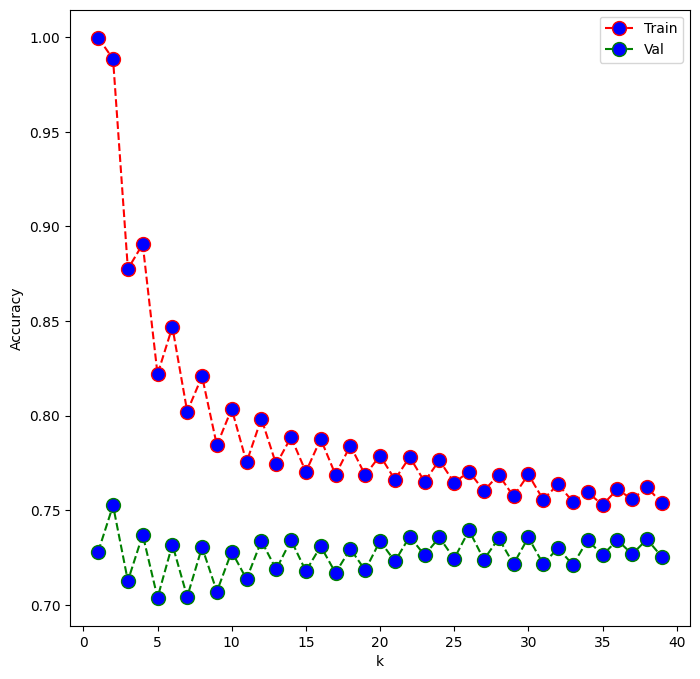

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(list(k_scores_train.keys()), list(k_scores_train.values()),
        color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10, label='Train')
ax.plot(list(k_scores_test.keys()), list(k_scores_test.values()),
        color='green', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10, label='Val')
ax.set_xlabel('k')
ax.set_ylabel('Accuracy')
plt.legend();

In [ ]:
knn_final = KNeighborsClassifier(n_neighbors=26)

knn_pipe_final = ImPipeline(steps=[
      ('ct', CT3),
      ("enricher", enricher),
      ('sm',SMOTE(random_state=42)),
      ('knn',knn_final)
  ])

# Create a saved model object
knn_results = SaveModel(
    model=knn_pipe_final,
    model_name='KNN',
    X_train=X_train,
    y_train=y_train,
    X_train_test=X_train_test,
    y_train_test=y_train_test,
    X_test=X_test,
    y_test=y_test,
    X_val=X_val,
    y_val=y_val,
    )

# Fit and score on train and test data
knn_results.score_model_train_test()

# Add the model to our list of modesl
model_dict.add_model(knn_results)

<ipython-input-155-1b579c8aabfd>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_scores = self.model_scores.append(model.model_scores)
<ipython-input-155-1b579c8aabfd>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_cv_results = self.model_cv_results.append(model.cv_summary)


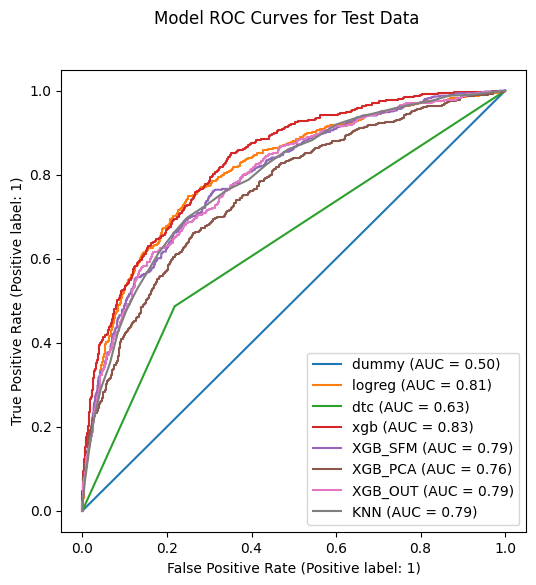

In [ ]:
model_dict.plot_models_roc_curves('test')

In [ ]:
model_dict.show_cv_results()

model                  CV Results
0    dummy  0.76691 ± 0.00614 accuracy
0   logreg  0.76051 ± 0.01188 accuracy
0      dtc  0.73411 ± 0.00779 accuracy
0      xgb  0.81441 ± 0.00582 accuracy
0  XGB_SFM  0.79691 ± 0.00645 accuracy
0  XGB_PCA  0.75442 ± 0.01168 accuracy
0  XGB_OUT  0.79566 ± 0.00424 accuracy
0      KNN  0.72192 ± 0.01263 accuracy

## Polynomial Features

In [ ]:
grad_boost_poly = XGBClassifier(random_state=42, objective='binary:logistic', nthread=-1)

# Create the subpipe for the numeric variables
subpipe_numerics_poly = Pipeline(steps = [
    ('num_impute', SimpleImputer(strategy='median')),
    ('ss', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('sfm',SelectFromModel(XGBClassifier(random_state=42, objective='binary:logistic', nthread=-1), max_features=10))
])

# Create the subpipe for the one-hot encoded variables
subpipe_cat_poly = Pipeline(steps=[
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'))
])

# Create the column transformer
CT_POLY = ColumnTransformer(transformers=[
    ('subpipe_num', subpipe_numerics_poly, selector(dtype_include=np.number)),
    ('subpipe_cat', subpipe_cat_poly, selector(dtype_include=object))
], remainder='passthrough')

xgb_poly_pipe = ImPipeline(steps=[
        ('ct', CT_POLY),
        ('sm',SMOTE(random_state=42)),
        ('xgb',grad_boost_poly)
    ])

# Create a saved model object
xgb_poly_results = SaveModel(
    model=xgb_poly_pipe,
    model_name='XGB_POLY',
    X_train=X_train,
    y_train=y_train,
    X_train_test=X_train_test,
    y_train_test=y_train_test,
    X_test=X_test,
    y_test=y_test,
    X_val=X_val,
    y_val=y_val,
    )

# Fit and score on train and test data
xgb_poly_results.score_model_train_test()

# Add the model to our list of modesl
model_dict.add_model(xgb_poly_results)

<ipython-input-155-1b579c8aabfd>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_scores = self.model_scores.append(model.model_scores)
<ipython-input-155-1b579c8aabfd>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_cv_results = self.model_cv_results.append(model.cv_summary)


In [ ]:
model_dict.show_cv_results()

model                  CV Results
0     dummy  0.76691 ± 0.00614 accuracy
0    logreg  0.76051 ± 0.01188 accuracy
0       dtc  0.73411 ± 0.00779 accuracy
0       xgb  0.81441 ± 0.00582 accuracy
0   XGB_SFM  0.79691 ± 0.00645 accuracy
0   XGB_PCA  0.75442 ± 0.01168 accuracy
0   XGB_OUT  0.79566 ± 0.00424 accuracy
0       KNN  0.72192 ± 0.01263 accuracy
0  XGB_POLY  0.78472 ± 0.00838 accuracy

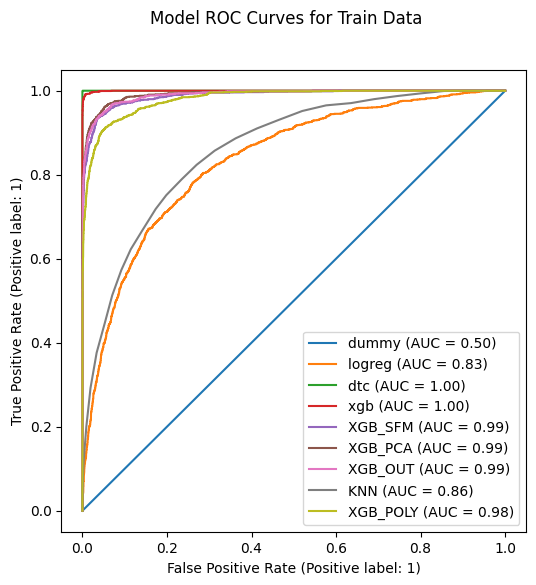

In [ ]:
model_dict.plot_models_roc_curves('train')

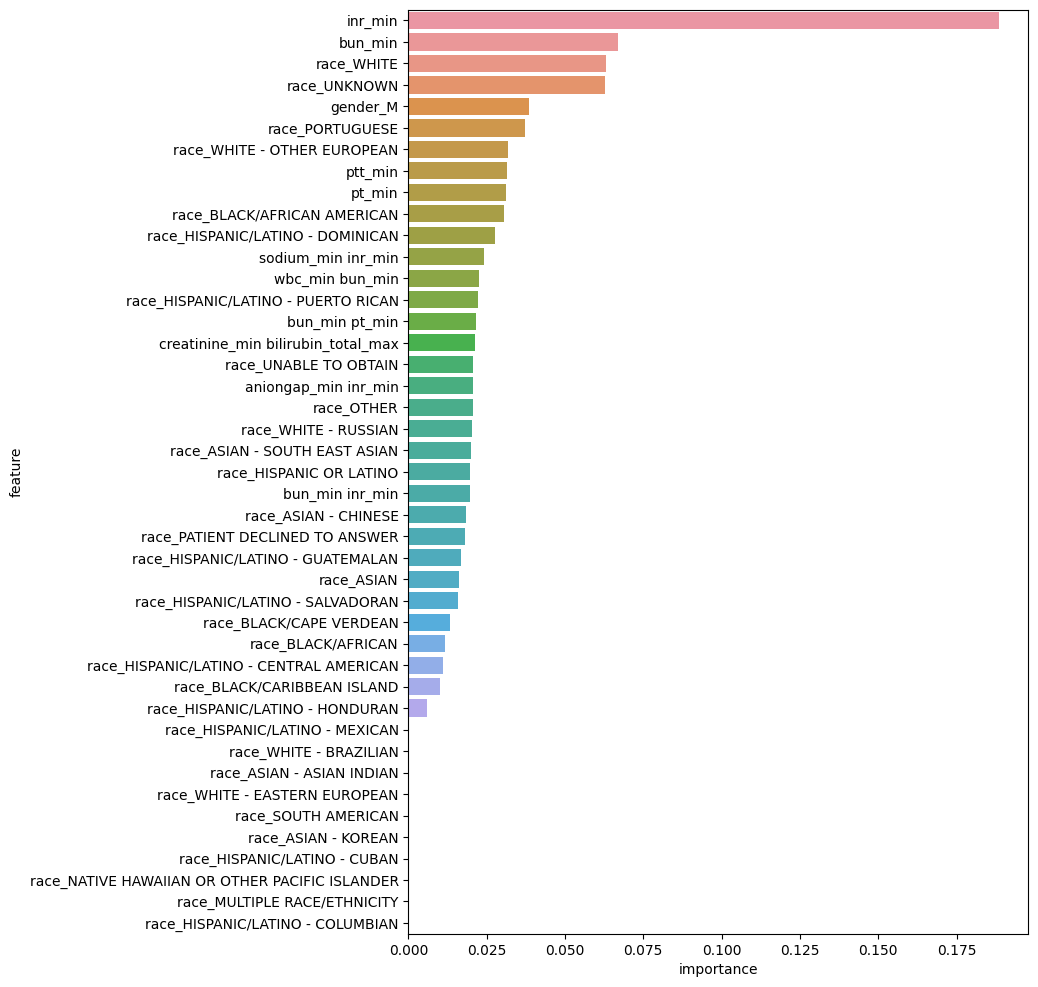

In [ ]:
xgb_features = pd.DataFrame()

y = model_dict.models['XGB_POLY'].model.named_steps.ct.get_feature_names_out()
xgb_features['feature'] = [val.split("__")[1] for val in y]

xgb_features['importance'] = pd.DataFrame(model_dict.models['XGB_POLY'].model.named_steps.xgb.feature_importances_).astype(float)[0]

xgb_features = xgb_features.sort_values(by='importance', ascending=False)

fig, ax = plt.subplots(figsize=(8,12))
sns.barplot(data=xgb_features, y='feature', x='importance', ax=ax);

## Clustering

### Kmeans

In [ ]:
km_data_scaled = CT2.transform(X_train)
silhouette_scores = []
for j in range(2, 3):
    clusters = KMeans(n_clusters=j, random_state=42, n_init=10)
    cluster_labels = clusters.fit_predict(km_data_scaled)
    silhouette = silhouette_score(km_data_scaled, cluster_labels)
    silhouette_scores.append(silhouette)

In [ ]:
print(np.argmax(silhouette_scores))

0


In [ ]:
# Create a custom column selector to add in the clustering
from sklearn.base import BaseEstimator, TransformerMixin

class Kmean_cluster(BaseEstimator, TransformerMixin):
    '''select specific columns of a given dataset'''

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_df = pd.DataFrame(X)
        kmeans = KMeans(n_clusters=2, random_state=42, n_init=10).fit_predict(X)
        X_df['kmeans_cluster'] = kmeans
        return np.array(X_df)

## test the Kmean_cluster class
kmeans_cluster = Kmean_cluster()
kmeans_cluster.transform(num_cols.fillna(0))

array([[18, 32.8, 35.6, ..., 1.2, 0, 0],
       [18, 33.4, 33.4, ..., 0.0, 0, 0],
       [18, 40.0, 40.0, ..., 0.9, 0, 0],
       ...,
       [95, 41.2, 41.2, ..., 0.0, 1, 0],
       [95, 34.6, 36.5, ..., 0.0, 1, 0],
       [96, 21.4, 28.2, ..., 0.6, 0, 0]], dtype=object)

In [ ]:
grad_boost_clus = XGBClassifier(random_state=42, objective='reg:squarederror')

# Create pipelines
xgb_pipe_clus = ImPipeline(steps=[
        ('ct', CT2),
        ('km', Kmean_cluster()),
        ('sm',SMOTE(random_state=42)),
        ('xgb',grad_boost_clus)
    ])

# Create a saved model object
xgb_pipe_clus_results = SaveModel(
    model=xgb_pipe_clus,
    model_name='xgb_clus',
    X_train=X_train,
    y_train=y_train,
    X_train_test=X_train_test,
    y_train_test=y_train_test,
    X_test=X_test,
    y_test=y_test,
    X_val=X_val,
    y_val=y_val,
    )

# Fit and score on train and test data
xgb_pipe_clus_results.score_model_train_test()

# Add the model to the dictionary
model_dict.add_model(xgb_pipe_clus_results)

<ipython-input-155-1b579c8aabfd>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_scores = self.model_scores.append(model.model_scores)
<ipython-input-155-1b579c8aabfd>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_cv_results = self.model_cv_results.append(model.cv_summary)


In [ ]:
model_dict.show_cv_results()

model                  CV Results
0     dummy  0.76691 ± 0.00614 accuracy
0    logreg  0.76051 ± 0.01188 accuracy
0       dtc  0.73411 ± 0.00779 accuracy
0       xgb  0.81441 ± 0.00582 accuracy
0   XGB_SFM  0.79691 ± 0.00645 accuracy
0   XGB_PCA  0.75442 ± 0.01168 accuracy
0   XGB_OUT  0.79566 ± 0.00424 accuracy
0       KNN  0.72192 ± 0.01263 accuracy
0  XGB_POLY  0.78472 ± 0.00838 accuracy
0  xgb_clus  0.79003 ± 0.00911 accuracy

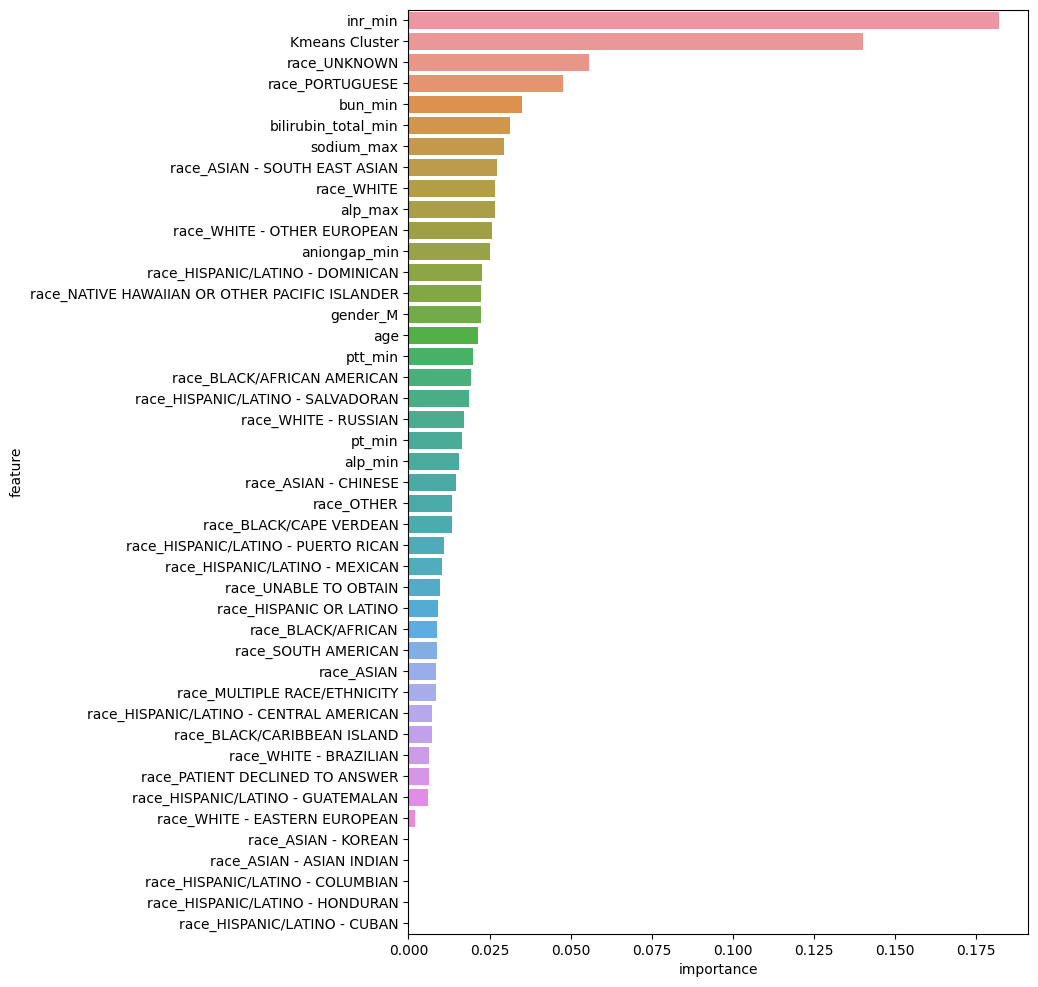

In [ ]:
xgb_features = pd.DataFrame()

y = model_dict.models['xgb_clus'].model.named_steps.ct.get_feature_names_out()
y = [val.split("__")[1] for val in y]
y.append('Kmeans Cluster')
xgb_features['feature'] = y

xgb_features['importance'] = pd.DataFrame(model_dict.models['xgb_clus'].model.named_steps.xgb.feature_importances_).astype(float)[0]

xgb_features = xgb_features.sort_values(by='importance', ascending=False)

fig, ax = plt.subplots(figsize=(8,12))
sns.barplot(data=xgb_features, y='feature', x='importance', ax=ax);

## Neural Network

In [ ]:
!pip install scikeras

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import StratifiedKFold

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
# Create a custom column selector to transform data to pandas dataframe for neural network
from sklearn.base import BaseEstimator, TransformerMixin

class Pandas_CT(BaseEstimator, TransformerMixin):
    '''Transform data to pandas dataframe'''

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return pd.DataFrame(X)

## test the Kmean_cluster class
nn_pandas_df = Pandas_CT()
nn_pandas_df.transform(X_train).head()

race gender  age  hematocrit_min  hematocrit_max  \
10513  BLACK/AFRICAN AMERICAN      F   76            21.5            27.0   
11051                   WHITE      F   82            26.6            32.0   
10728         ASIAN - CHINESE      M   78            37.6            47.4   
6809                    WHITE      F   61            27.3            32.5   
8398                    WHITE      M   66            25.3            30.6   

       hemoglobin_min  hemoglobin_max  platelets_min  platelets_max  wbc_min  \
10513             6.9             8.8           95.0          127.0      5.8   
11051             7.9             9.5          519.0          618.0     15.9   
10728            12.3            15.0          209.0          241.0      7.9   
6809              8.4            10.4           56.0          108.0      9.4   
8398              8.9            10.8          340.0          418.0     10.1   

       ...  ptt_min  ptt_max  alt_min  alt_max  alp_min  alp_max  ast_min  \
10513  ...     22.2     31.8      9.0     11.0     61.0     71.0     17.0   
11051  ...     29.4     34.6     33.0     97.0    126.0    136.0    164.0   
10728  ...     30.4     30.4     16.0     16.0     73.0     73.0     36.0   
6809   ...     32.3     43.5   1512.0   2025.0     61.0     93.0   1298.0   
8398   ...     29.1     37.4      NaN      NaN      NaN      NaN      NaN   

       ast_max  bilirubin_total_min  bilirubin_total_max  
10513     25.0                  0.4                  0.5  
11051    470.0                  1.9                  5.1  
10728     36.0                  0.8                  0.8  
6809    1691.0                  0.4                  1.3  
8398       NaN                  NaN                  NaN  

[5 rows x 53 columns]

In [ ]:
def create_baseline():
# create model
  model = Sequential()
  model.add(Dense(60, input_shape=(84,), activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  # Compile model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:
nn_base = KerasClassifier(model=create_baseline, epochs=100, batch_size=5, verbose=0)

nn_base_pipe = ImPipeline(steps=[
      ('ct', CT),
      ('sm',SMOTE(random_state=42)),
      ('pct',Pandas_CT()),
      ('nn_base',nn_base)
  ])

# Create a saved model object
nn_base_pipe_results = SaveModel(
    model=nn_base_pipe,
    model_name='nn_base',
    X_train=X_train,
    y_train=y_train,
    X_train_test=X_train_test,
    y_train_test=y_train_test,
    X_test=X_test,
    y_test=y_test,
    X_val=X_val,
    y_val=y_val,
    )

# Fit and score on train and test data
nn_base_pipe_results.score_model_train_test()

# Add the model to the dictionary
model_dict.add_model(nn_base_pipe_results)

<ipython-input-155-1b579c8aabfd>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_scores = self.model_scores.append(model.model_scores)
<ipython-input-155-1b579c8aabfd>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_cv_results = self.model_cv_results.append(model.cv_summary)


In [ ]:
model_dict.show_cv_results()

model                  CV Results
0     dummy  0.76691 ± 0.00614 accuracy
0    logreg  0.76051 ± 0.01188 accuracy
0       dtc  0.73411 ± 0.00779 accuracy
0       xgb  0.81441 ± 0.00582 accuracy
0   XGB_SFM  0.79691 ± 0.00645 accuracy
0   XGB_PCA  0.75442 ± 0.01168 accuracy
0   XGB_OUT  0.79566 ± 0.00424 accuracy
0       KNN  0.72192 ± 0.01263 accuracy
0  XGB_POLY  0.78472 ± 0.00838 accuracy
0  xgb_clus  0.79003 ± 0.00911 accuracy
0   nn_base  0.75410 ± 0.00971 accuracy

## Model Optimization

I will optimize two different sets of models, one set using the whole dataset and one set trying to minimise the number of features. I will be focusing on using XGBoost and neural networks since they have had the highest accuracy (>80% cross validation accuracy)



### Full Features

#### Logistic Regression

In [106]:
lr_gs_model = LogisticRegression(random_state=42)

# Create pipelines
lr_gs_pipe = ImPipeline(steps=[
        ('ct', CT),
        ('sm',SMOTE(random_state=42)),
        ('lr',lr_gs_model)
    ])

params = dict()
params['lr__solver'] = ['newton-cg', 'lbfgs', 'liblinear']
params['lr__penalty'] = ['l1', 'l2', 'elasticnet']
params['lr__C'] = loguniform(1e-5, 100)

clf = RandomizedSearchCV(lr_gs_pipe,
                         params,
                         scoring = 'accuracy',
                         verbose = 3,
                         random_state=42)
lr_gs = clf.fit(X_train, y_train)
lr_gs.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END lr__C=0.004185822729546973, lr__penalty=l1, lr__solver=liblinear;, score=0.563 total time=   0.6s
[CV 2/5] END lr__C=0.004185822729546973, lr__penalty=l1, lr__solver=liblinear;, score=0.574 total time=   0.4s
[CV 3/5] END lr__C=0.004185822729546973, lr__penalty=l1, lr__solver=liblinear;, score=0.579 total time=   0.2s
[CV 4/5] END lr__C=0.004185822729546973, lr__penalty=l1, lr__solver=liblinear;, score=0.583 total time=   0.2s
[CV 5/5] END lr__C=0.004185822729546973, lr__penalty=l1, lr__solver=liblinear;, score=0.538 total time=   0.2s
[CV 1/5] END lr__C=1.330324510152291, lr__penalty=l1, lr__solver=newton-cg;, score=nan total time=   0.1s
[CV 2/5] END lr__C=1.330324510152291, lr__penalty=l1, lr__solver=newton-cg;, score=nan total time=   0.1s
[CV 3/5] END lr__C=1.330324510152291, lr__penalty=l1, lr__solver=newton-cg;, score=nan total time=   0.1s
[CV 4/5] END lr__C=1.330324510152291, lr__penalty=l1, lr__solver=n

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)

{'lr__C': 0.0013480180290890802,
 'lr__penalty': 'l2',
 'lr__solver': 'newton-cg'}

In [107]:
# Create a saved model object
lr_gs_pipe_results = SaveModel(
    model=lr_gs.best_estimator_,
    model_name='LR_GS',
    X_train=X_train,
    y_train=y_train,
    X_train_test=X_train_test,
    y_train_test=y_train_test,
    X_test=X_test,
    y_test=y_test,
    X_val=X_val,
    y_val=y_val,
    )

# Fit and score on train and test data
lr_gs_pipe_results.score_model_train_test()

# Add the model to the dictionary
model_dict.add_model(lr_gs_pipe_results)

<ipython-input-17-1b579c8aabfd>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_scores = self.model_scores.append(model.model_scores)
<ipython-input-17-1b579c8aabfd>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_cv_results = self.model_cv_results.append(model.cv_summary)


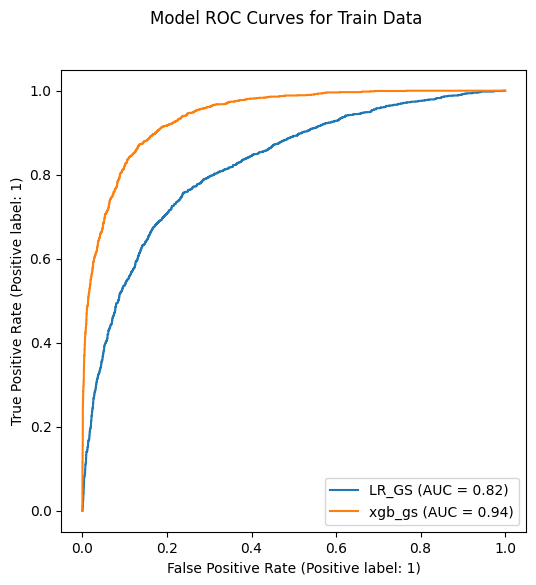

In [108]:
model_dict.plot_models_roc_curves('train')

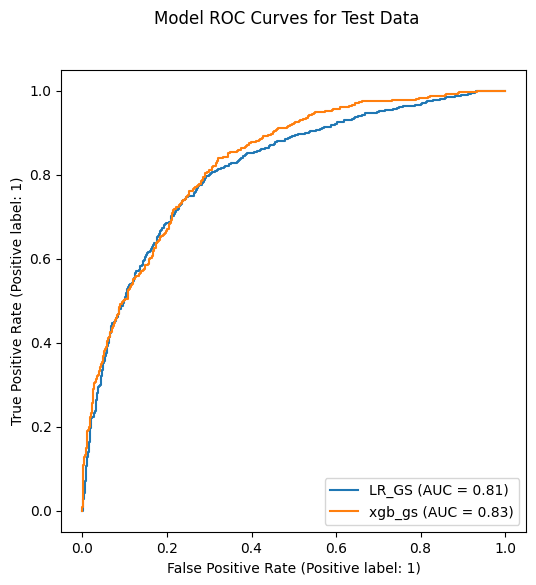

In [109]:
model_dict.plot_models_roc_curves('test')

In [110]:
model_dict.show_cv_results()

model                  CV Results
0   LR_GS  0.76723 ± 0.01599 accuracy
0  xgb_gs  0.82065 ± 0.00844 accuracy
0  xgb_gs  0.81753 ± 0.01131 accuracy
0   LR_GS  0.76723 ± 0.01599 accuracy

#### XGBoost

In [20]:
# Set up Pipeline
grad_boost_xgb_gs = XGBClassifier(n_estimators=600,
                                  random_state=42,
                                  objective='binary:logistic'
                                  )

# Create the subpipe for the numeric variables
subpipe_numerics_xgb_gs = Pipeline(steps = [
    ('num_impute', SimpleImputer(strategy='median')),
    ('ss', StandardScaler()),
])

# Create the subpipe for the one-hot encoded variables
subpipe_cat_xgb_gs = Pipeline(steps=[
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'))
])

# Create the column transformer
CT_XGB_GS = ColumnTransformer(transformers=[
    ('subpipe_num', subpipe_numerics_xgb_gs, selector(dtype_include=np.number)),
    ('subpipe_cat', subpipe_cat_xgb_gs, selector(dtype_include=object))
], remainder='passthrough')

# Create pipelines
xgb_gs_pipe = ImPipeline(steps=[
        ('ct', CT_XGB_GS),
        ('sm',SMOTE(random_state=42)),
        ('xgb',grad_boost_xgb_gs)
    ])

Now that we've set up our pipeline let's gridsearch it

In [26]:
params = {
 'xgb__learning_rate' : [0.05,0.10,0.15,0.20,0.25,0.30],
 'xgb__max_depth' : [2, 3, 4, 5, 6, 8, 10, 12, 15],
 'xgb__min_child_weight' : [ 1, 3, 5, 7 ],
 'xgb__gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 'xgb__colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7 ]
}

clf = RandomizedSearchCV(xgb_gs_pipe,
                         params,
                         scoring = 'accuracy',
                         verbose = 3,
                         random_state=42)
xgb_gs = clf.fit(X_train, y_train)
xgb_gs.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END xgb__colsample_bytree=0.3, xgb__gamma=0.3, xgb__learning_rate=0.3, xgb__max_depth=15, xgb__min_child_weight=1;, score=0.807 total time=  14.7s
[CV 2/5] END xgb__colsample_bytree=0.3, xgb__gamma=0.3, xgb__learning_rate=0.3, xgb__max_depth=15, xgb__min_child_weight=1;, score=0.828 total time=  17.9s
[CV 3/5] END xgb__colsample_bytree=0.3, xgb__gamma=0.3, xgb__learning_rate=0.3, xgb__max_depth=15, xgb__min_child_weight=1;, score=0.825 total time=  15.1s
[CV 4/5] END xgb__colsample_bytree=0.3, xgb__gamma=0.3, xgb__learning_rate=0.3, xgb__max_depth=15, xgb__min_child_weight=1;, score=0.806 total time=  14.9s
[CV 5/5] END xgb__colsample_bytree=0.3, xgb__gamma=0.3, xgb__learning_rate=0.3, xgb__max_depth=15, xgb__min_child_weight=1;, score=0.798 total time=  14.5s
[CV 1/5] END xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.15, xgb__max_depth=12, xgb__min_child_weight=1;, score=0.820 total time=  26.2s
[C

KeyboardInterrupt: ignored

In [22]:
# Create a saved model object
xgb_pipe_gs_results = SaveModel(
    model=xgb_gs.best_estimator_,
    model_name='xgb_gs',
    X_train=X_train,
    y_train=y_train,
    X_train_test=X_train_test,
    y_train_test=y_train_test,
    X_test=X_test,
    y_test=y_test,
    X_val=X_val,
    y_val=y_val,
    )

# Fit and score on train and test data
xgb_pipe_gs_results.score_model_train_test()

# Add the model to the dictionary
model_dict.add_model(xgb_pipe_gs_results)

<ipython-input-17-1b579c8aabfd>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_scores = self.model_scores.append(model.model_scores)
<ipython-input-17-1b579c8aabfd>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_cv_results = self.model_cv_results.append(model.cv_summary)


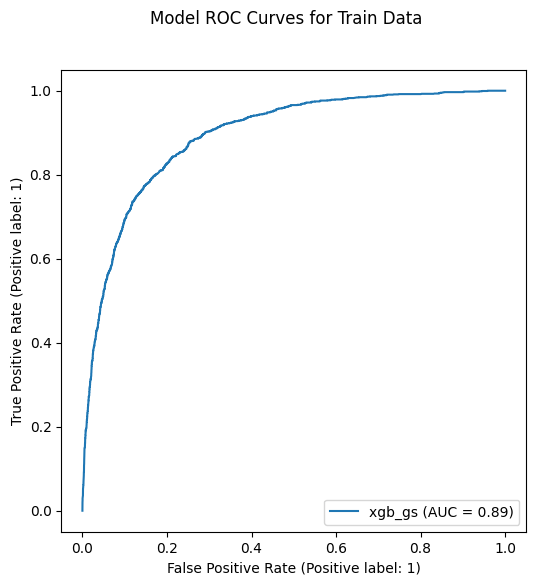

In [23]:
model_dict.plot_models_roc_curves('train')

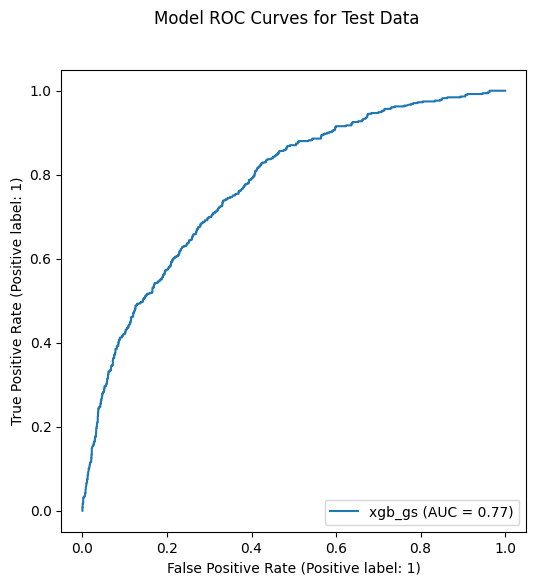

In [24]:
model_dict.plot_models_roc_curves('test')

In [25]:
model_dict.show_cv_results()

model                  CV Results
0  xgb_gs  0.77426 ± 0.00989 accuracy

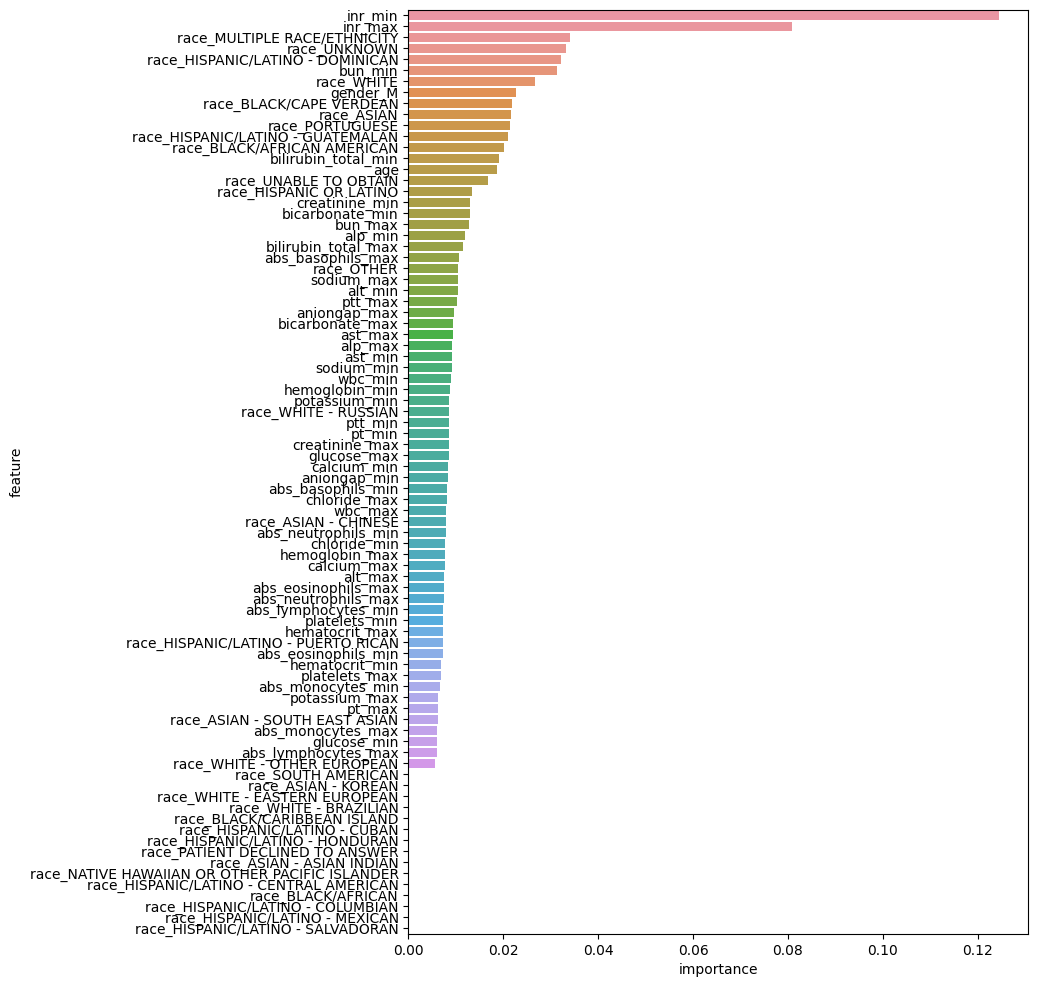

In [ ]:
xgb_features = pd.DataFrame()

y = model_dict.models['xgb_gs'].model.named_steps.ct.get_feature_names_out()
y = [val.split("__")[1] for val in y]
xgb_features['feature'] = y

xgb_features['importance'] = pd.DataFrame(model_dict.models['xgb_gs'].model.named_steps.xgb.feature_importances_).astype(float)[0]

xgb_features = xgb_features.sort_values(by='importance', ascending=False)

fig, ax = plt.subplots(figsize=(8,12))
sns.barplot(data=xgb_features, y='feature', x='importance', ax=ax);

#### Neural Network

In [ ]:
from tensorflow.keras.regularizers import l2

In [ ]:
def create_optimized_nn():
# create model, inspiration https://www.atmosera.com/blog/binary-classification-with-neural-networks/
  model = Sequential()
  model.add(Dense(512, input_shape=(84,), activation='relu', kernel_regularizer=l2(l2=0.01)))
  model.add(Dense(512, activation='relu', kernel_regularizer=l2(l2=0.01)))
  model.add(Dense(1, activation='sigmoid'))
  # Compile model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:
nn_opt = KerasClassifier(model=create_optimized_nn, epochs=40, batch_size=10)

nn_opt_pipe = ImPipeline(steps=[
      ('ct', CT),
      ('sm',SMOTE(random_state=42)),
      ('pct',Pandas_CT()),
      ('nn',nn_opt)
  ])

# Create a saved model object
nn_opt_pipe_results = SaveModel(
    model=nn_opt_pipe,
    model_name='NN_OPT',
    X_train=X_train,
    y_train=y_train,
    X_train_test=X_train_test,
    y_train_test=y_train_test,
    X_test=X_test,
    y_test=y_test,
    X_val=X_val,
    y_val=y_val,
    )

# Fit and score on train and test data
nn_opt_pipe_results.score_model_train_test()

# Add the model to the dictionary
model_dict.add_model(nn_opt_pipe_results)

Epoch 1/40
982/982 [==============================] - 4s 3ms/step - loss: 0.8866 - accuracy: 0.7411
Epoch 2/40
982/982 [==============================] - 3s 3ms/step - loss: 0.5436 - accuracy: 0.7612
Epoch 3/40
982/982 [==============================] - 3s 3ms/step - loss: 0.5322 - accuracy: 0.7669
Epoch 4/40
982/982 [==============================] - 3s 3ms/step - loss: 0.5218 - accuracy: 0.7744
Epoch 5/40
982/982 [==============================] - 3s 3ms/step - loss: 0.5134 - accuracy: 0.7762
Epoch 6/40
982/982 [==============================] - 3s 3ms/step - loss: 0.5086 - accuracy: 0.7839
Epoch 7/40
982/982 [==============================] - 3s 3ms/step - loss: 0.5037 - accuracy: 0.7873
Epoch 8/40
982/982 [==============================] - 3s 3ms/step - loss: 0.4996 - accuracy: 0.7863
Epoch 9/40
982/982 [==============================] - 3s 3ms/step - loss: 0.4946 - accuracy: 0.7947
Epoch 10/40
982/982 [==============================] - 3s 3ms/step - loss: 0.4918 - accuracy: 0.7925

<ipython-input-155-1b579c8aabfd>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_scores = self.model_scores.append(model.model_scores)
<ipython-input-155-1b579c8aabfd>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_cv_results = self.model_cv_results.append(model.cv_summary)


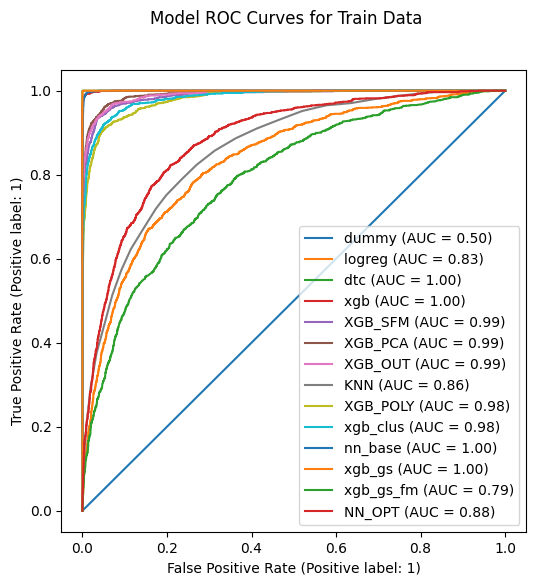

In [ ]:
model_dict.plot_models_roc_curves('train')

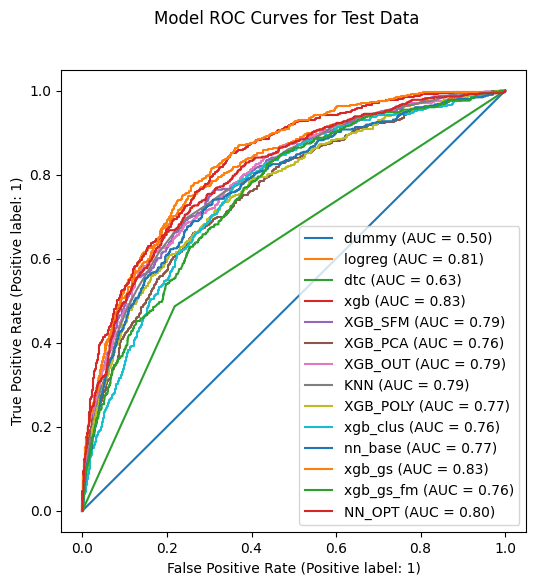

In [ ]:
model_dict.plot_models_roc_curves('test')

In [ ]:
model_dict.show_cv_results()

model                  CV Results
0      dummy  0.76691 ± 0.00614 accuracy
0     logreg  0.76051 ± 0.01188 accuracy
0        dtc  0.73411 ± 0.00779 accuracy
0        xgb  0.81441 ± 0.00582 accuracy
0    XGB_SFM  0.79691 ± 0.00645 accuracy
0    XGB_PCA  0.75442 ± 0.01168 accuracy
0    XGB_OUT  0.79566 ± 0.00424 accuracy
0        KNN  0.72192 ± 0.01263 accuracy
0   XGB_POLY  0.78472 ± 0.00838 accuracy
0   xgb_clus  0.79003 ± 0.00911 accuracy
0    nn_base  0.75410 ± 0.00971 accuracy
0     xgb_gs  0.82003 ± 0.00795 accuracy
0    nn_base  0.78894 ± 0.01126 accuracy
0  xgb_gs_fm  0.73723 ± 0.01507 accuracy
0     NN_OPT  0.77847 ± 0.00763 accuracy

### Feature Selection

#### XGBoost

First we need to create the pipeline with:
- Imputing
- Scaling
- One hot encoding
- Polynomial features
- Select from model (5 features to match MELD)
- Kmeans clustering
- XGBoost classifier (estimator)

In [ ]:
# Set up Pipeline
grad_boost_xgb_gs_fs = XGBClassifier(random_state=42, objective='binary:logistic')

# Create the subpipe for the numeric variables
subpipe_numerics_xgb_gs_fs = Pipeline(steps = [
    ('num_impute', SimpleImputer(strategy='median')),
    ('ss', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('sfm',SelectFromModel(XGBClassifier(random_state=42, objective='binary:logistic', nthread=-1), max_features=5))
])

# Create the subpipe for the one-hot encoded variables
subpipe_cat_xgb_gs_fs = Pipeline(steps=[
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'))
])

# Create the column transformer
CT_XGB_GS_FS = ColumnTransformer(transformers=[
    ('subpipe_num', subpipe_numerics_xgb_gs_fs, selector(dtype_include=np.number)),
    ('subpipe_cat', subpipe_cat_xgb_gs_fs, selector(dtype_include=object))
], remainder='passthrough')

# Create pipelines
xgb_gs_fs_pipe = ImPipeline(steps=[
        ('ct', CT_XGB_GS_FS),
        ('km', Kmean_cluster()),
        ('sm',SMOTE(random_state=42)),
        ('xgb',grad_boost_xgb_gs_fs)
    ])

In [ ]:
params = {
 'xgb__learning_rate' : [0.05,0.10,0.15,0.20,0.25,0.30],
 'xgb__max_depth' : [2, 3, 4, 5, 6, 8, 10, 12, 15],
 'xgb__min_child_weight' : [ 1, 3, 5, 7 ],
 'xgb__gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 'xgb__colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7 ]
}

gs_xgb_fs = RandomizedSearchCV(xgb_gs_fs_pipe,
                         params,
                         scoring = 'roc_auc',
                         verbose = 3,
                         random_state=42)
xgb_gs_fs = gs_xgb_fs.fit(X_train, y_train)
xgb_gs_fs.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END xgb__colsample_bytree=0.3, xgb__gamma=0.3, xgb__learning_rate=0.3, xgb__max_depth=15, xgb__min_child_weight=1;, score=0.741 total time=  48.1s
[CV 2/5] END xgb__colsample_bytree=0.3, xgb__gamma=0.3, xgb__learning_rate=0.3, xgb__max_depth=15, xgb__min_child_weight=1;, score=0.743 total time=  47.2s
[CV 3/5] END xgb__colsample_bytree=0.3, xgb__gamma=0.3, xgb__learning_rate=0.3, xgb__max_depth=15, xgb__min_child_weight=1;, score=0.745 total time=  48.7s
[CV 4/5] END xgb__colsample_bytree=0.3, xgb__gamma=0.3, xgb__learning_rate=0.3, xgb__max_depth=15, xgb__min_child_weight=1;, score=0.764 total time=  45.9s
[CV 5/5] END xgb__colsample_bytree=0.3, xgb__gamma=0.3, xgb__learning_rate=0.3, xgb__max_depth=15, xgb__min_child_weight=1;, score=0.733 total time=  48.2s
[CV 1/5] END xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.15, xgb__max_depth=12, xgb__min_child_weight=1;, score=0.754 total time=  49.3s
[C

{'xgb__min_child_weight': 7,
 'xgb__max_depth': 2,
 'xgb__learning_rate': 0.2,
 'xgb__gamma': 0.3,
 'xgb__colsample_bytree': 0.5}

In [ ]:
# Create a saved model object
xgb_pipe_gs_results = SaveModel(
    model=xgb_gs_fs.best_estimator_,
    model_name='xgb_gs_fm',
    X_train=X_train,
    y_train=y_train,
    X_train_test=X_train_test,
    y_train_test=y_train_test,
    X_test=X_test,
    y_test=y_test,
    X_val=X_val,
    y_val=y_val,
    )

# Fit and score on train and test data
xgb_pipe_gs_results.score_model_train_test()

# Add the model to the dictionary
model_dict.add_model(xgb_pipe_gs_results)

<ipython-input-155-1b579c8aabfd>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_scores = self.model_scores.append(model.model_scores)
<ipython-input-155-1b579c8aabfd>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_cv_results = self.model_cv_results.append(model.cv_summary)


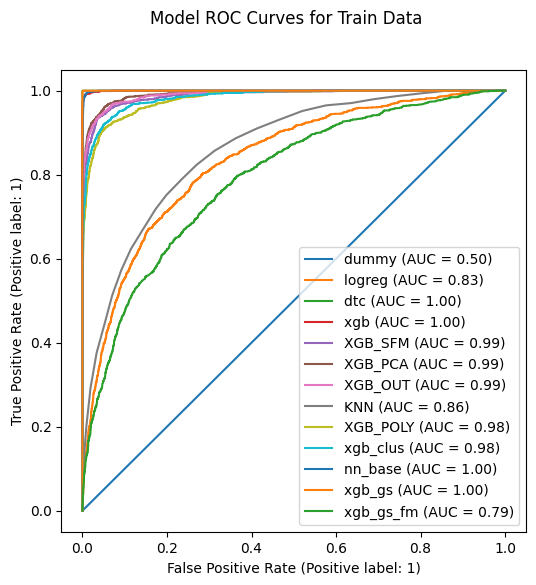

In [ ]:
model_dict.plot_models_roc_curves('train')

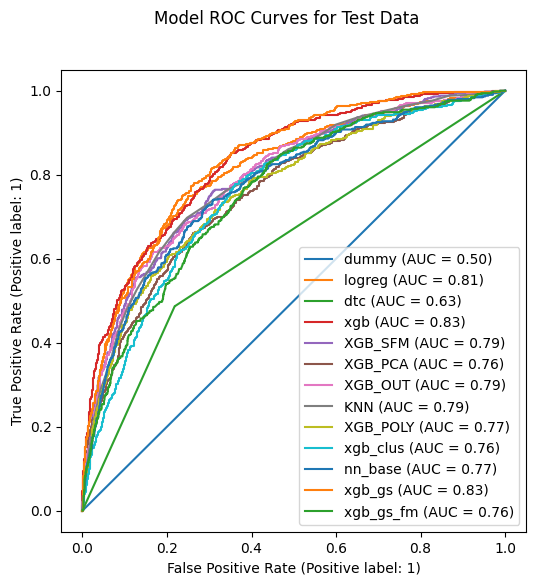

In [ ]:
model_dict.plot_models_roc_curves('test')

In [ ]:
model_dict.show_cv_results()

model                  CV Results
0      dummy  0.76691 ± 0.00614 accuracy
0     logreg  0.76051 ± 0.01188 accuracy
0        dtc  0.73411 ± 0.00779 accuracy
0        xgb  0.81441 ± 0.00582 accuracy
0    XGB_SFM  0.79691 ± 0.00645 accuracy
0    XGB_PCA  0.75442 ± 0.01168 accuracy
0    XGB_OUT  0.79566 ± 0.00424 accuracy
0        KNN  0.72192 ± 0.01263 accuracy
0   XGB_POLY  0.78472 ± 0.00838 accuracy
0   xgb_clus  0.79003 ± 0.00911 accuracy
0    nn_base  0.75410 ± 0.00971 accuracy
0     xgb_gs  0.82003 ± 0.00795 accuracy
0    nn_base  0.78894 ± 0.01126 accuracy
0  xgb_gs_fm  0.73723 ± 0.01507 accuracy

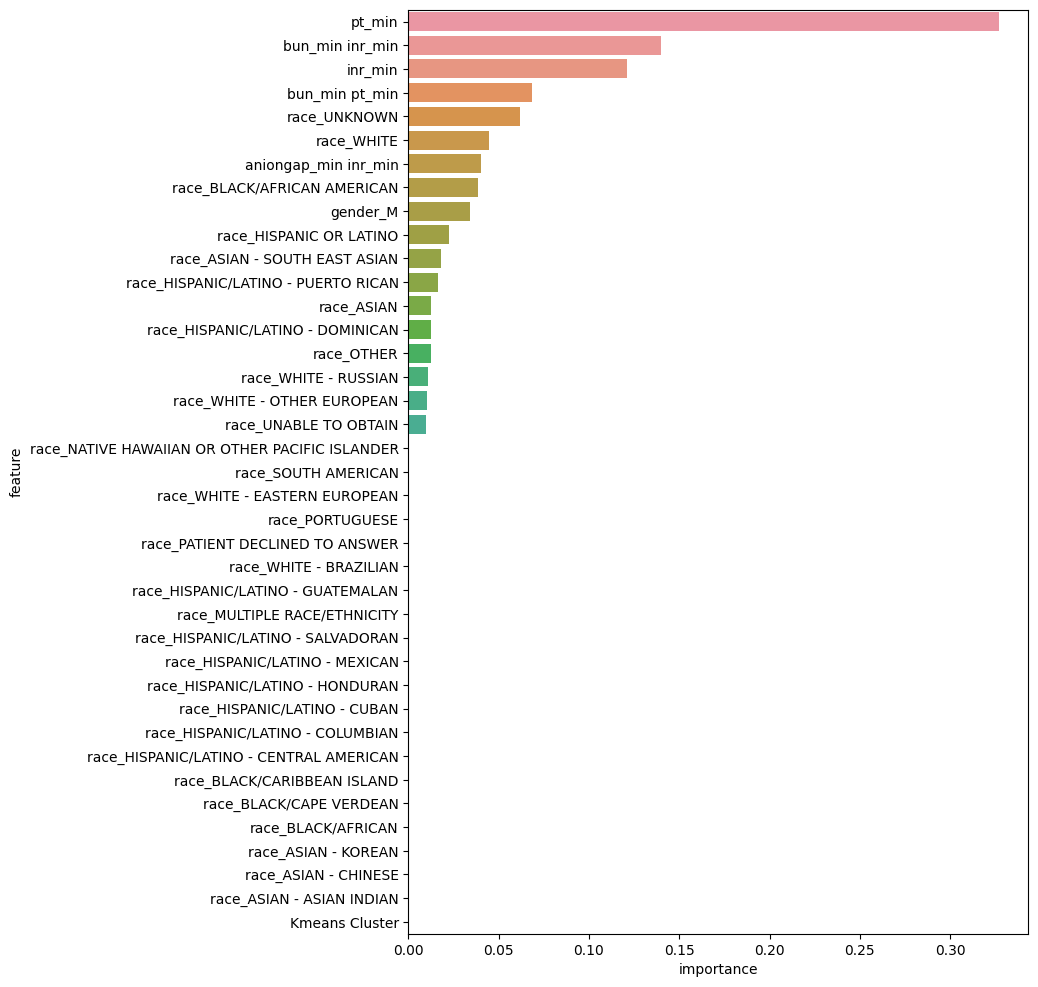

In [ ]:
xgb_features = pd.DataFrame()

y = model_dict.models['xgb_gs_fm'].model.named_steps.ct.get_feature_names_out()
y = [val.split("__")[1] for val in y]
y.append('Kmeans Cluster')
xgb_features['feature'] = y

xgb_features['importance'] = pd.DataFrame(model_dict.models['xgb_gs_fm'].model.named_steps.xgb.feature_importances_).astype(float)[0]

xgb_features = xgb_features.sort_values(by='importance', ascending=False)

fig, ax = plt.subplots(figsize=(8,12))
sns.barplot(data=xgb_features, y='feature', x='importance', ax=ax);

# Final Model Productionize

In [27]:
model_dict.show_cv_results()

model                  CV Results
0  xgb_gs  0.77426 ± 0.00989 accuracy

So far our best performing model by cross validation accuracy is our gridsearched XGBoost model at 0.82

In [28]:
model_dict.models['xgb_gs'].model

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb521bf42e0>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent'))...
                               feature_types=None, gamma=0.0, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=8, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=5,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

In [36]:
model_dict.validate_models()

<ipython-input-18-6d1b5006f10e>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_scores = self.model_scores.append(
<ipython-input-17-1b579c8aabfd>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.model_scores = self.model_scores.append(model_data[val_filter])


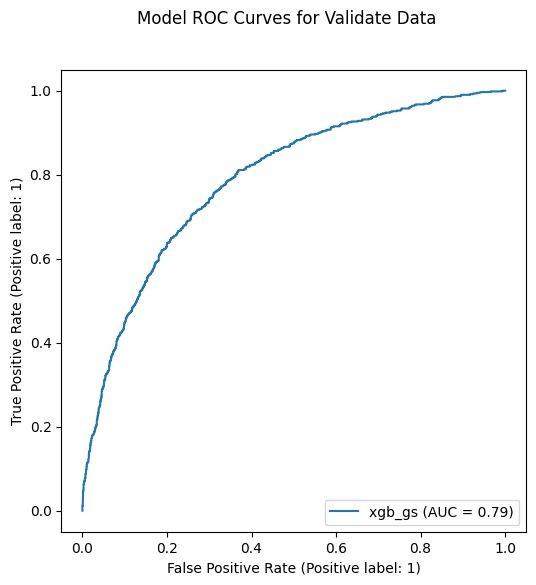

In [37]:
model_dict.plot_models_roc_curves('validate')

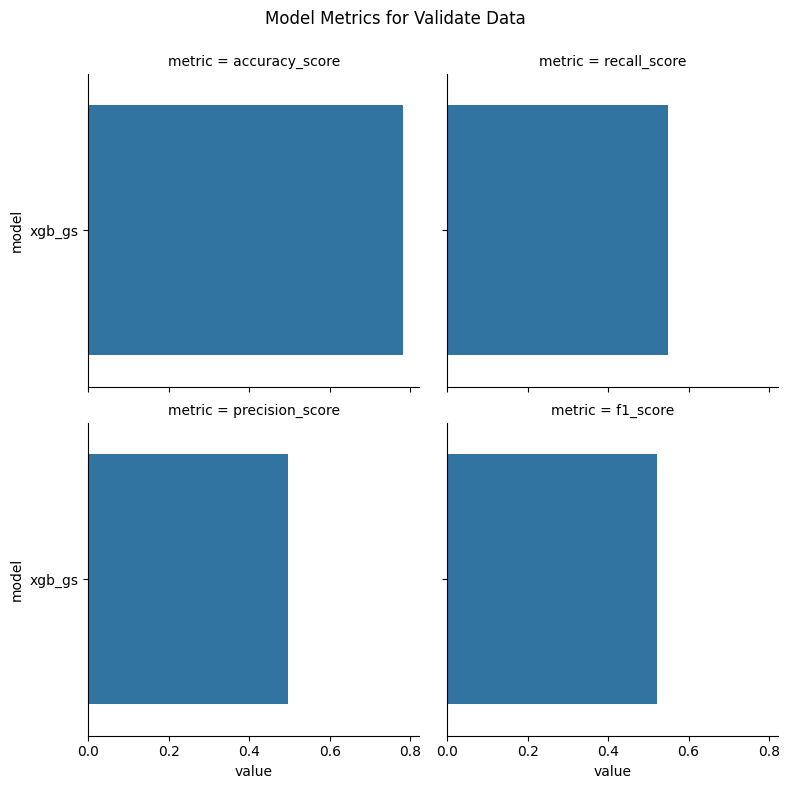

In [39]:
model_dict.plot_models_scores('validate')

In [41]:
model_dict.models['xgb_gs'].model_scores

model   dataset           metric     value
0  xgb_gs     train   accuracy_score  0.847055
1  xgb_gs     train     recall_score  0.719169
2  xgb_gs     train  precision_score  0.657073
3  xgb_gs     train         f1_score  0.686720
4  xgb_gs      test   accuracy_score  0.757732
5  xgb_gs      test     recall_score  0.542240
6  xgb_gs      test  precision_score  0.492857
7  xgb_gs      test         f1_score  0.516370
0  xgb_gs  validate   accuracy_score  0.782853
1  xgb_gs  validate     recall_score  0.548860
2  xgb_gs  validate  precision_score  0.497050
3  xgb_gs  validate         f1_score  0.521672

In [40]:
# Select the final model
final_model = model_dict.models['xgb_gs'].model

In [42]:
# Production model
final_model.fit(X,y)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb521bf42e0>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent'))...
                               feature_types=None, gamma=0.0, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=8, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=5,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

## Deployment
From this [tutorial](https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/automl/automl-tabular-classification.ipynb#scrollTo=59a46204cddb)

In [114]:
# Install the packages
# ! pip3 install --quiet --upgrade google-cloud-aiplatform \
                                 google-cloud-storage

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.6/114.6 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.3/321.3 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 82.3 MB/s eta 0:00:00


In [139]:
# Automatically restart kernel after installs so that your environment can access the new packages
# import IPython

# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

Set the region for your bucket

In [29]:
REGION = "us-central1"  # @param {type: "string"}

In [30]:
PROJECT_ID = "mimic-iv-388714"  # @param {type:"string"}

# Set the project id
! gcloud config set project {PROJECT_ID}

Updated property [core/project].


Create a cloud storage bucket

In [31]:
BUCKET_URI = f"gs://mimic-iv-data-{PROJECT_ID}-unique"

In [124]:
# Only if your bucket doesn't exist
# ! gsutil mb -l $REGION $BUCKET_URI

Creating gs://mimic-iv-data-mimic-iv-388714-unique/...


Write data to the storage bucket

In [32]:
from google.cloud import storage

In [135]:
client = storage.Client()
BUCKET = f"mimic-iv-data-{PROJECT_ID}-unique"
bucket = client.get_bucket(BUCKET)

# The name assigned to the CSV file on GCS
# blob = bucket.blob('mimic_iv.csv')
# blob.upload_from_string(df_clean.to_csv(), 'text/csv')

**Import Vertex AI SDK for Python**

Import the Vertex AI SDK into your Python environment and initialize it.

In [33]:
from google.cloud import aiplatform

aiplatform.init(project=PROJECT_ID, location=REGION)

**Create a Managed Tabular Dataset from a CSV**

This section will create a dataset from a CSV file stored on your GCS bucket.

In [35]:
IMPORT_FILE = 'mimic_iv.csv'
gcs_source = f"{BUCKET_URI}/data/{IMPORT_FILE}"

ds = dataset = aiplatform.TabularDataset.create(
    display_name="mimic-iv-dataset",
    gcs_source=gcs_source,
)

ds.resource_name

Creating TabularDataset


INFO:google.cloud.aiplatform.datasets.dataset:Creating TabularDataset


Create TabularDataset backing LRO: projects/971032098585/locations/us-central1/datasets/7912294580685373440/operations/2747790814645059584


INFO:google.cloud.aiplatform.datasets.dataset:Create TabularDataset backing LRO: projects/971032098585/locations/us-central1/datasets/7912294580685373440/operations/2747790814645059584


TabularDataset created. Resource name: projects/971032098585/locations/us-central1/datasets/7912294580685373440


INFO:google.cloud.aiplatform.datasets.dataset:TabularDataset created. Resource name: projects/971032098585/locations/us-central1/datasets/7912294580685373440


To use this TabularDataset in another session:


INFO:google.cloud.aiplatform.datasets.dataset:To use this TabularDataset in another session:


ds = aiplatform.TabularDataset('projects/971032098585/locations/us-central1/datasets/7912294580685373440')


INFO:google.cloud.aiplatform.datasets.dataset:ds = aiplatform.TabularDataset('projects/971032098585/locations/us-central1/datasets/7912294580685373440')


'projects/971032098585/locations/us-central1/datasets/7912294580685373440'

In [44]:
import joblib
import logging

# set logging to see the docker container logs
logging.basicConfig(level=logging.INFO)

In [47]:
MODEL_ARTIFACT_DIR = "sklearn-model-artifacts"
joblib.dump(final_model, 'model_artifacts/model.joblib')

!gsutil cp model_artifacts/model.joblib {BUCKET_URI}/{MODEL_ARTIFACT_DIR}/

FileNotFoundError: ignored